# Preprocesamiento y Visualización de Datos - VCT Match Prediction
## Dataset de Partidas Competitivas de Valorant

**Autores:**
- Marc Escribano Sierra
- David Morais Caldas

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn optuna scipy --quiet

Note: you may need to restart the kernel to use updated packages.


---

## 1. Importación de Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna 

from scipy.stats import ttest_rel, wilcoxon
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings

import json
import os
import pickle

# Modelos Lineales/Cuadráticos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modelos no lineales
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Validación y métricas
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

# Supresión de warnings de Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

# Configuración de estilo visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## 2. Carga y Exploración Inicial de los Datos

In [3]:
# Carga del dataset
df = pd.read_csv('vct_match_prediction_dataset_ML.csv')

print("Información básica del dataset")
print(f"Dimensiones: {df.shape}")
print(f"Características: {df.shape[1] - 1}")
print(f"Muestras: {df.shape[0]}")
print("\nPrimeras filas:")
print(df.head())

Información básica del dataset
Dimensiones: (31173, 37)
Características: 36
Muestras: 31173

Primeras filas:
   diff_rating  diff_acs  diff_adr  diff_kd  diff_fk  diff_headshot  \
0       0.0308    2.3690    0.8954   0.0382  -0.2696         5.2033   
1      -0.0308   -2.3690   -0.8954  -0.0382   0.2696        -5.2033   
2       0.0249    3.3245    1.1961   0.1653   0.4892        -2.3538   
3       0.1345   -0.1064    4.6385  -0.0033  -0.0999         1.5294   
4      -0.0678   -5.1845   -4.9303  -0.0948  -0.3994         3.5218   

   diff_star_power  diff_consistency  diff_recent_winrate  diff_map_winrate  \
0           0.3758            0.6742                 -0.0              -0.0   
1          -0.3758           -0.6742                  0.0               0.0   
2           0.0100           -0.1533                 -0.2               0.5   
3           0.1000           -0.0267                  0.2              -0.5   
4           0.1500            0.4200                  0.2            

In [4]:
print("\nTipos de datos y valores nulos:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())


Tipos de datos y valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31173 entries, 0 to 31172
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diff_rating              31173 non-null  float64
 1   diff_acs                 31173 non-null  float64
 2   diff_adr                 31173 non-null  float64
 3   diff_kd                  31173 non-null  float64
 4   diff_fk                  31173 non-null  float64
 5   diff_headshot            31173 non-null  float64
 6   diff_star_power          31173 non-null  float64
 7   diff_consistency         31173 non-null  float64
 8   diff_recent_winrate      31173 non-null  float64
 9   diff_map_winrate         31173 non-null  float64
 10  diff_agent_diversity     31173 non-null  float64
 11  h2h_advantage            31173 non-null  float64
 12  tournament_tier          31173 non-null  float64
 13  diff_streak              31173 non-null  in

---

## 3. Análisis de Calidad de los Datos

### 3.1 Verificación de Valores Perdidos

In [5]:
# Detección de valores perdidos por variable
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Variable': missing_values.index,
    'Valores Perdidos': missing_values.values,
    'Porcentaje (%)': missing_percentage.values
})

missing_df = missing_df[missing_df['Valores Perdidos'] > 0].sort_values('Valores Perdidos', ascending=False)

print("Análisis de valores perdidos")
if len(missing_df) == 0:
    print("No se detectaron valores perdidos en el dataset.")
else:
    print(f"\nVariables con valores perdidos: {len(missing_df)}")
    print(missing_df.to_string(index=False))

Análisis de valores perdidos
No se detectaron valores perdidos en el dataset.


### 3.2 Análisis de Valores Duplicados

In [6]:
duplicates = df.duplicated().sum()
print("Análisis de valores duplicados")
print(f"Filas duplicadas: {duplicates} ({(duplicates/len(df))*100:.2f}%)")

if duplicates > 0:
    df_clean = df.drop_duplicates()
    print(f"Filas eliminadas: {len(df) - len(df_clean)}")
    df = df_clean
else:
    print("No se detectaron valores duplicados.")

Análisis de valores duplicados
Filas duplicadas: 0 (0.00%)
No se detectaron valores duplicados.


### 3.3 Identificación de Tipos de Variables

In [7]:
# Clasificación de variables según su naturaleza
diff_features = [col for col in df.columns if col.startswith('diff_')]
interaction_features = [col for col in df.columns if 'interaction' in col or 'ratio' in col]
map_features = [col for col in df.columns if col.startswith('map_')]
year_features = [col for col in df.columns if col.startswith('year_')]
binary_features = ['is_playoff', 'is_grand_final', 'is_international']

target = 'winner'

print("Clasificación de variables")
print(f"Variables de diferencia: {len(diff_features)}")
print(f"Variables de interacción/ratio: {len(interaction_features)}")
print(f"Variables de mapas: {len(map_features)}")
print(f"Variables de año: {len(year_features)}")
print(f"Variables binarias: {len(binary_features)}")
print(f"Variable objetivo: {target}")
print(f"Total de características: {len(df.columns) - 1}")

Clasificación de variables
Variables de diferencia: 12
Variables de interacción/ratio: 4
Variables de mapas: 10
Variables de año: 4
Variables binarias: 3
Variable objetivo: winner
Total de características: 36


### 3.4 Análisis de Valores Atípicos (Outliers)

In [8]:
# Análisis de outliers mediante método IQR
continuous_vars = diff_features + interaction_features

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), (len(outliers) / len(data)) * 100

print("Análisis de outliers (método IQR)")

outlier_summary = []
for col in continuous_vars:
    n_outliers, pct_outliers = detect_outliers_iqr(df, col)
    if pct_outliers > 5:
        outlier_summary.append({
            'Variable': col,
            'N° Outliers': n_outliers,
            'Porcentaje (%)': pct_outliers
        })

if len(outlier_summary) > 0:
    outlier_df = pd.DataFrame(outlier_summary).sort_values('Porcentaje (%)', ascending=False)
    print("\nVariables con más del 5% de outliers:")
    print(outlier_df.to_string(index=False))
    print("\nNota: Los outliers se mantienen (partidas atípicas válidas).")
else:
    print("No se detectaron variables con más del 5% de outliers.")

Análisis de outliers (método IQR)



Variables con más del 5% de outliers:
               Variable  N° Outliers  Porcentaje (%)
   star_h2h_interaction         9363         30.0356
rating_form_interaction         5644         18.1054
                diff_fk         1886          6.0501

Nota: Los outliers se mantienen (partidas atípicas válidas).


### 3.5 Análisis de Distribución de la Variable Objetivo

In [9]:
# Análisis de balance de clases
print("Distribución de la variable objetivo")

target_counts = df[target].value_counts()
target_pct = df[target].value_counts(normalize=True) * 100

print(f"\nClase 0 (equipo 2 gana): {target_counts[0]} ({target_pct[0]:.2f}%)")
print(f"Clase 1 (equipo 1 gana): {target_counts[1]} ({target_pct[1]:.2f}%)")

balance_ratio = min(target_pct) / max(target_pct)
print(f"Ratio de balance: {balance_ratio:.2f}")

# Interpretación del balance
if balance_ratio > 0.8:
    print("Interpretación: clases bien balanceadas.")
elif balance_ratio > 0.6:
    print("Interpretación: ligero desbalance entre clases.")
else:
    print("Interpretación: desbalance significativo entre clases.")

Distribución de la variable objetivo

Clase 0 (equipo 2 gana): 15554 (49.90%)
Clase 1 (equipo 1 gana): 15619 (50.10%)
Ratio de balance: 1.00
Interpretación: clases bien balanceadas.


---

## 4. Preprocesamiento de Datos

### 4.1 Separación de Características y Variable Objetivo

In [10]:
X = df.drop(columns=[target])
y = df[target]

print("Separación de datos")
print(f"Características (X): {X.shape}")
print(f"Variable objetivo (y): {y.shape}")

Separación de datos
Características (X): (31173, 36)
Variable objetivo (y): (31173,)


### 4.2 Identificación de Variables a Escalar

In [11]:
print("Identificación de variables para escalado")

variables_to_scale = diff_features + interaction_features

print(f"Variables continuas: {len(variables_to_scale)}")
print(f"Variables binarias: {len(map_features + year_features + binary_features)}")

Identificación de variables para escalado
Variables continuas: 16
Variables binarias: 17


---

## 5. Visualización Exploratoria de Datos

### 5.1 Distribución de la Variable Objetivo

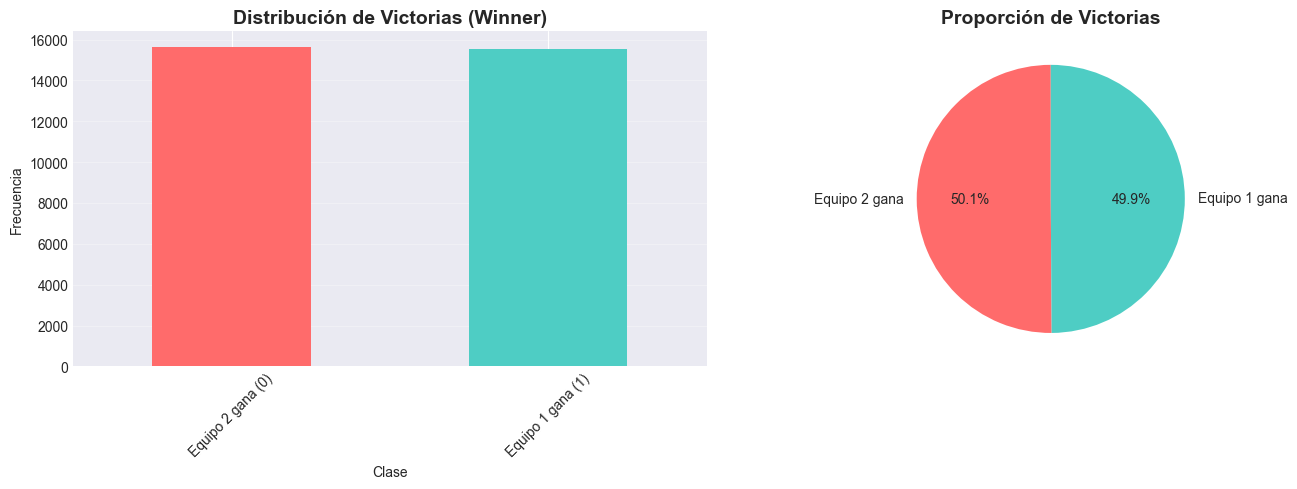

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
target_counts.plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Distribución de Victorias (Winner)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['Equipo 2 gana (0)', 'Equipo 1 gana (1)'], rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de pastel
colors = ['#ff6b6b', '#4ecdc4']
axes[1].pie(target_counts, labels=['Equipo 2 gana', 'Equipo 1 gana'], 
            autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Proporción de Victorias', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.2 Distribución de Variables Clave de Rendimiento

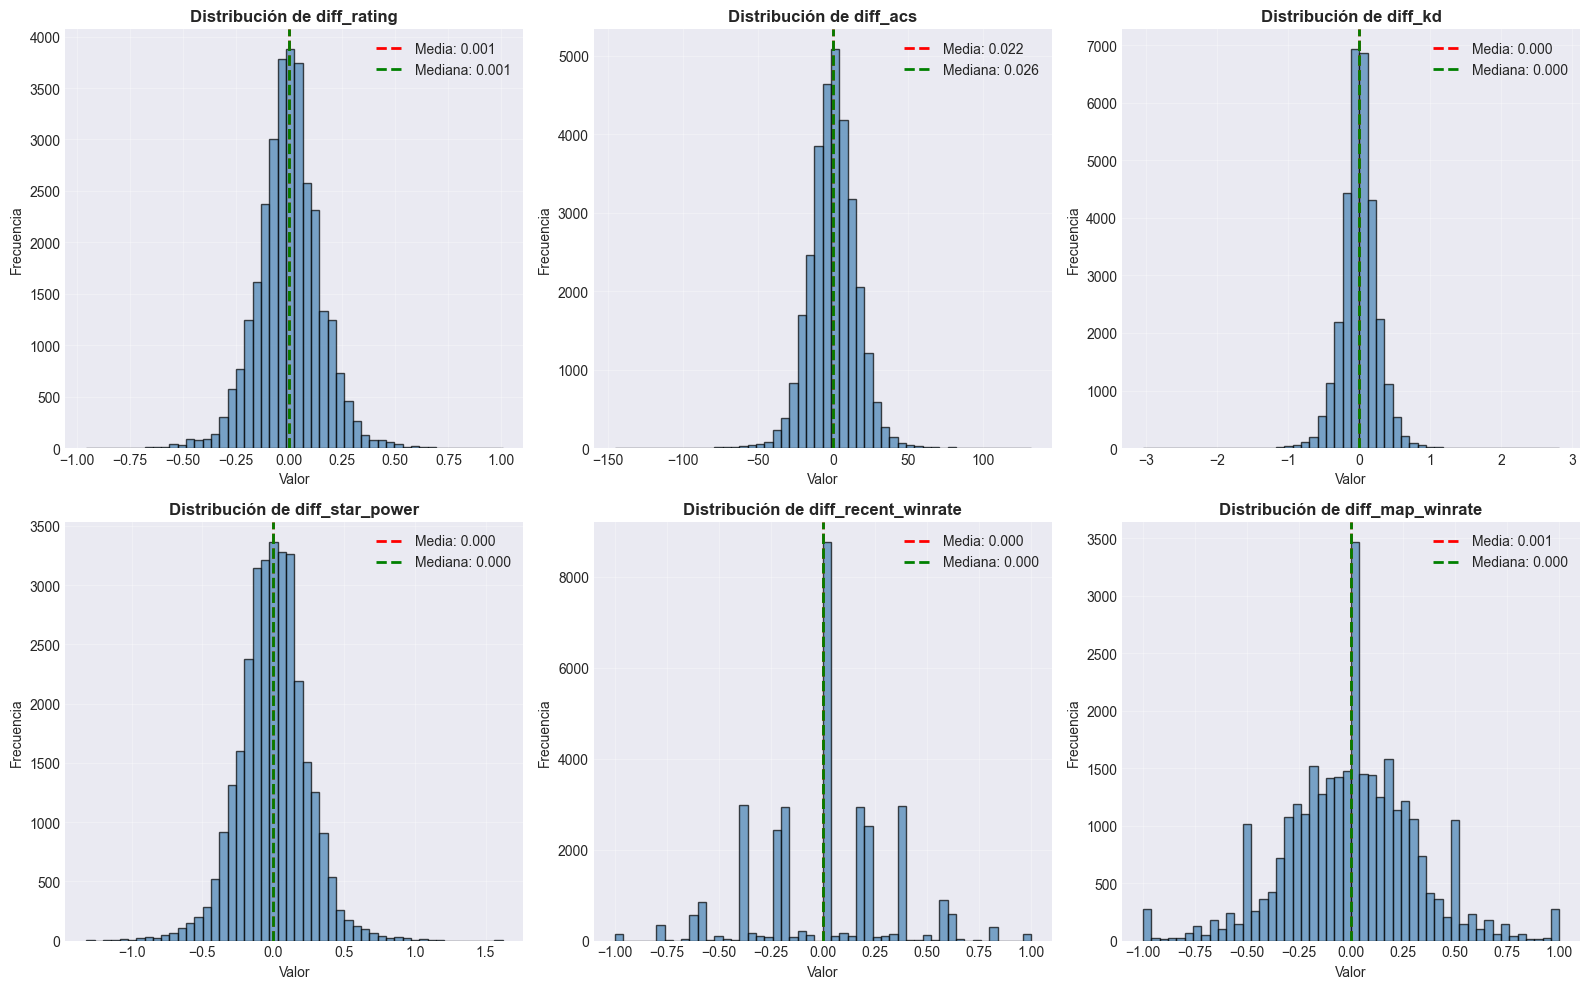

In [13]:
# Visualización de distribuciones de variables clave de rendimiento
key_performance_vars = [
    'diff_rating',           # Diferencia de rating promedio
    'diff_acs',              # Diferencia de Average Combat Score
    'diff_kd',               # Diferencia de Kill/Death ratio
    'diff_star_power',       # Diferencia del mejor jugador
    'diff_recent_winrate',   # Diferencia de win rate reciente
    'diff_map_winrate'       # Diferencia de win rate en el mapa
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, var in enumerate(key_performance_vars):
    # Histograma con líneas de tendencia central
    axes[idx].hist(df[var], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[idx].axvline(df[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df[var].mean():.3f}')
    axes[idx].axvline(df[var].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df[var].median():.3f}')
    axes[idx].set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Valor')
    axes[idx].set_ylabel('Frecuencia')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Análisis de Mapas y Años

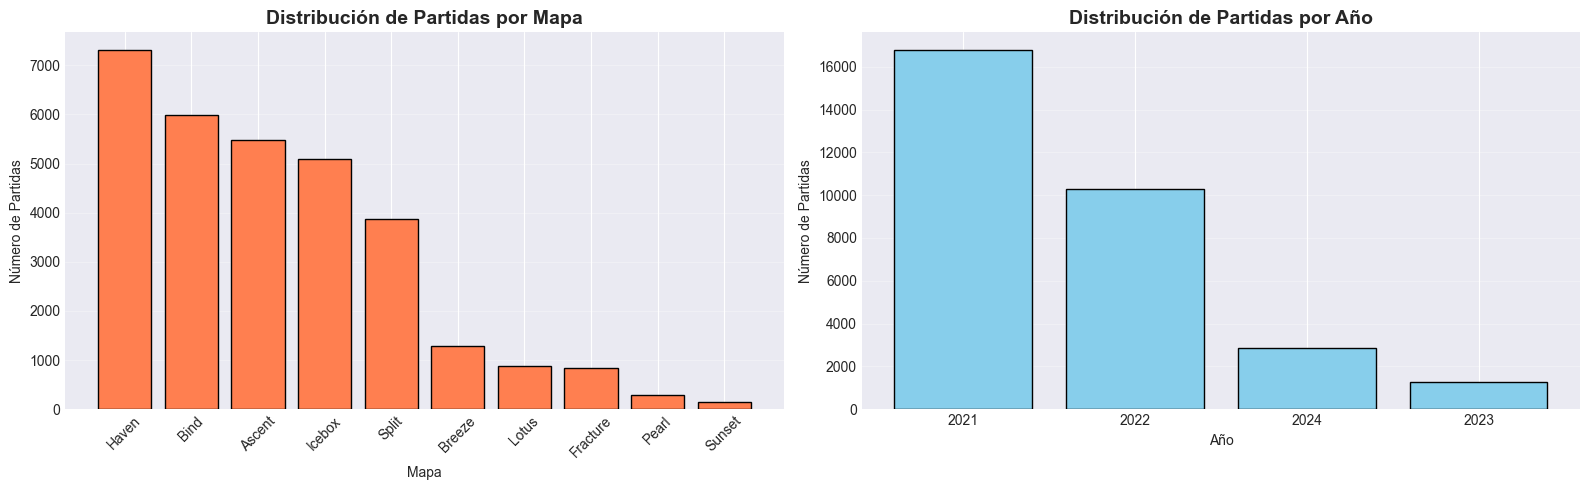


Mapa más jugado: Haven (7307 partidas)
Año con más partidas: 2021 (16769 partidas)


In [14]:
# Visualización de distribución por mapas y años
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribución de mapas
map_counts = df[map_features].sum().sort_values(ascending=False)
map_names = [m.replace('map_', '') for m in map_counts.index]
axes[0].bar(map_names, map_counts.values, color='coral', edgecolor='black')
axes[0].set_title('Distribución de Partidas por Mapa', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mapa')
axes[0].set_ylabel('Número de Partidas')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Distribución por año
year_counts = df[year_features].sum().sort_values(ascending=False)
year_names = [y.replace('year_', '') for y in year_counts.index]
axes[1].bar(year_names, year_counts.values, color='skyblue', edgecolor='black')
axes[1].set_title('Distribución de Partidas por Año', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Número de Partidas')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMapa más jugado: {map_names[0]} ({map_counts.values[0]} partidas)")
print(f"Año con más partidas: {year_names[0]} ({year_counts.values[0]} partidas)")

### 5.4 Contexto de las Partidas (Playoffs, Grand Finals, Internacional)

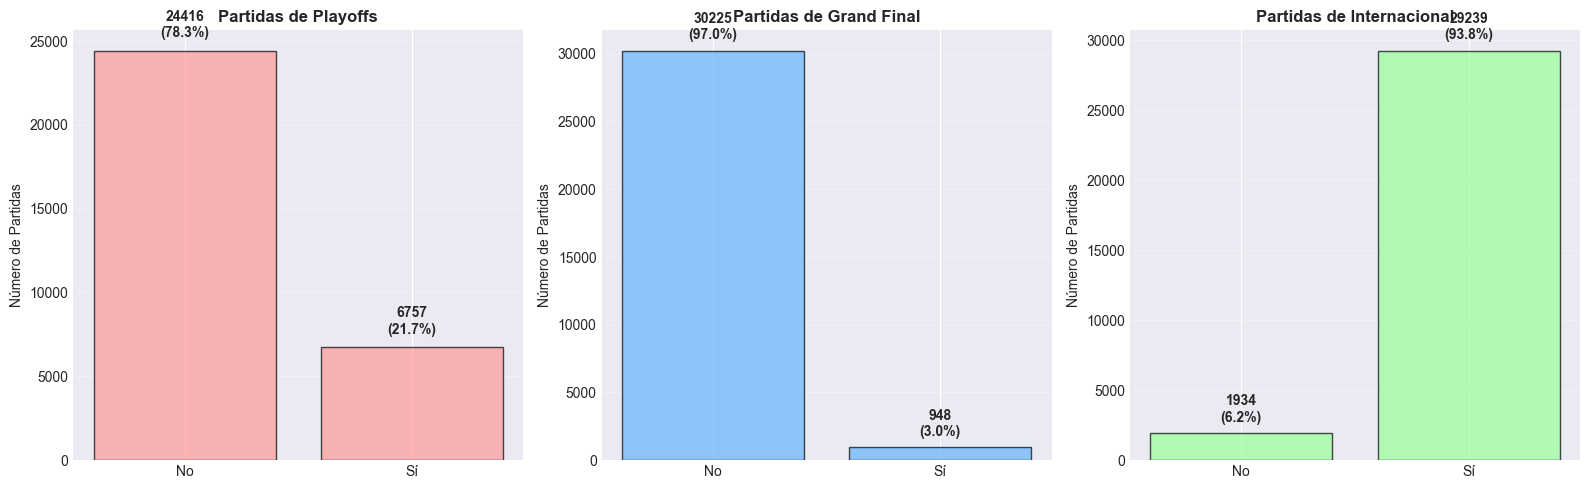

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

context_vars = ['is_playoff', 'is_grand_final', 'is_international']
context_labels = ['Playoffs', 'Grand Final', 'Internacional']
colors_context = ['#ff9999', '#66b3ff', '#99ff99']

for idx, (var, label, color) in enumerate(zip(context_vars, context_labels, colors_context)):
    counts = df[var].value_counts().sort_index()
    axes[idx].bar(['No', 'Sí'], counts.values, color=color, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Partidas de {label}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Número de Partidas')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Añadir porcentajes
    total = counts.sum()
    for i, v in enumerate(counts.values):
        axes[idx].text(i, v + total*0.02, f'{v}\n({v/total*100:.1f}%)', 
                      ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 5.5 Matriz de Correlación (Variables Clave)

Analizando correlación con todas las variables numéricas
Total de variables: 20


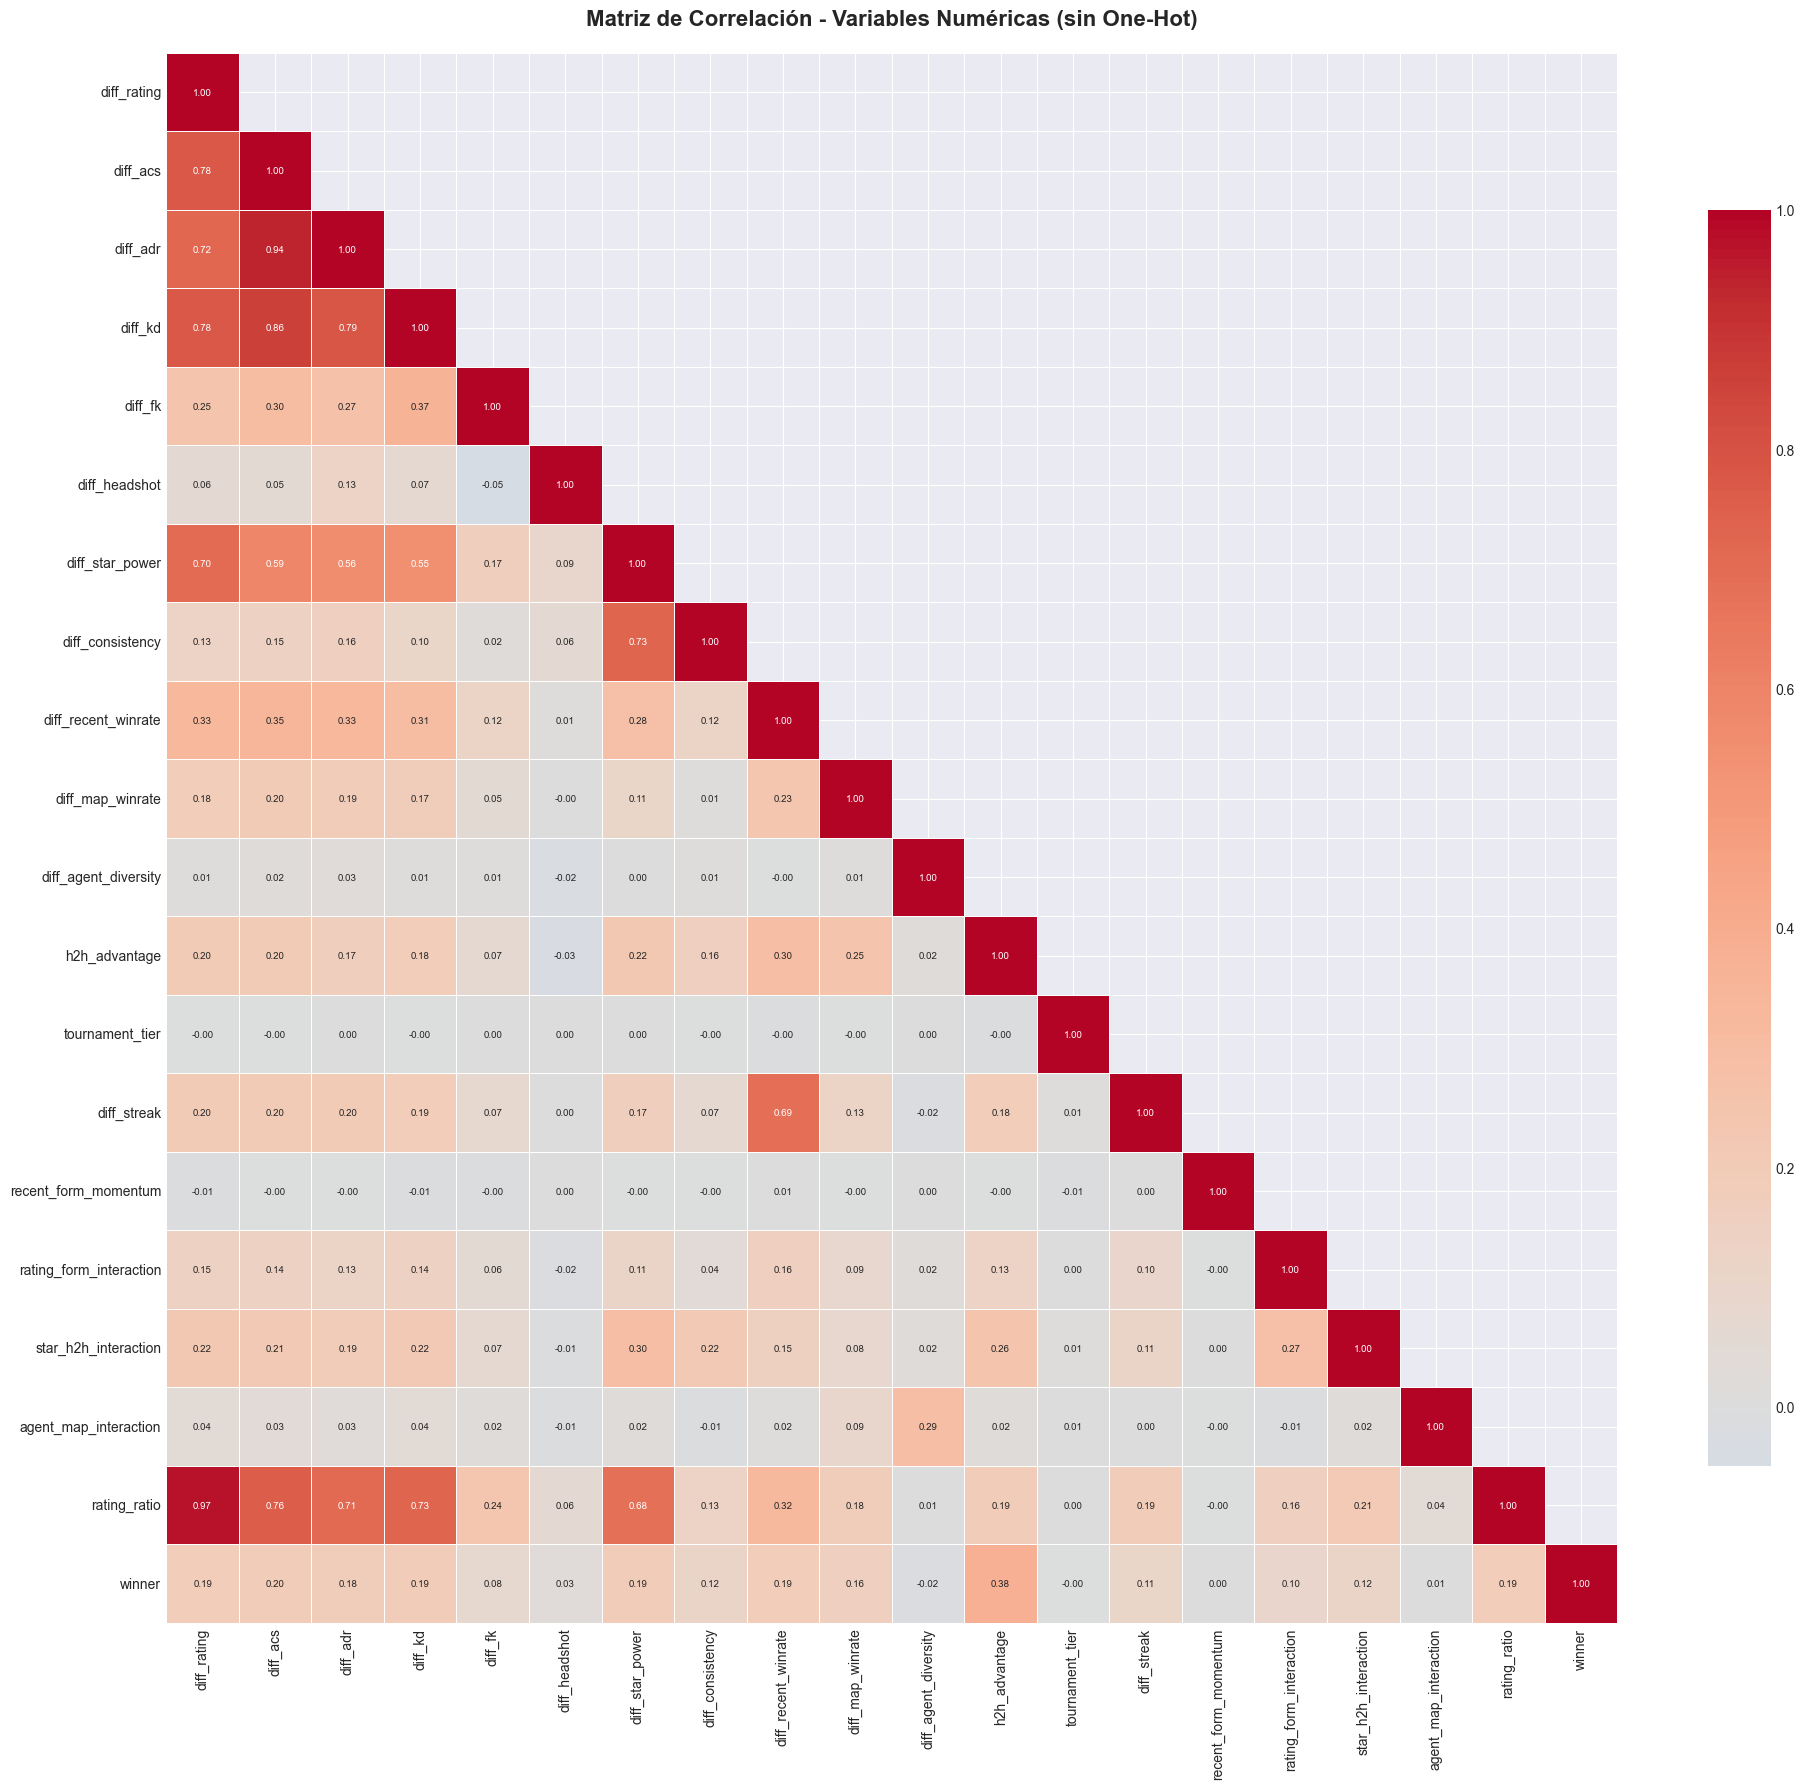


Correlaciones con la variable objetivo (winner)
h2h_advantage              0.3820
diff_acs                   0.1963
diff_kd                    0.1910
diff_star_power            0.1884
diff_rating                0.1883
rating_ratio               0.1854
diff_recent_winrate        0.1852
diff_adr                   0.1771
diff_map_winrate           0.1569
star_h2h_interaction       0.1185
diff_consistency           0.1167
diff_streak                0.1085
rating_form_interaction    0.1013
diff_fk                    0.0772
diff_headshot              0.0275
agent_map_interaction      0.0070
recent_form_momentum       0.0015
tournament_tier           -0.0025
diff_agent_diversity      -0.0160

Top 10 variables con mayor correlación absoluta con 'winner'
  h2h_advantage                 :  0.3820 (positiva)
  diff_acs                      :  0.1963 (positiva)
  diff_kd                       :  0.1910 (positiva)
  diff_star_power               :  0.1884 (positiva)
  diff_rating                  

In [16]:
# Usar todas las variables numéricas excepto one-hot y variables binarias de contexto
# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir:
# - Columnas one-hot de mapas (map_Haven, map_Bind, etc.)
# - Columnas one-hot de años (year_2021, year_2022, etc.)
# - Variables binarias de contexto (is_playoff, is_grand_final, is_international)
excluded_prefixes = ['map_', 'year_', 'is_']
correlation_vars = [col for col in numeric_cols 
                   if not any(col.startswith(prefix) for prefix in excluded_prefixes)]

# Asegurar que 'winner' esté incluida
if 'winner' not in correlation_vars and 'winner' in df.columns:
    correlation_vars.append('winner')

print("Analizando correlación con todas las variables numéricas")
print(f"Total de variables: {len(correlation_vars)}")

# Calcular matriz de correlación
corr_matrix = df[correlation_vars].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(20, 18))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 7})
plt.title('Matriz de Correlación - Variables Numéricas (sin One-Hot)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Mostrar las correlaciones más fuertes con la variable objetivo
if 'winner' in corr_matrix.columns:
    print("\nCorrelaciones con la variable objetivo (winner)")
    corr_with_target = corr_matrix['winner'].drop('winner').sort_values(ascending=False)
    print(corr_with_target.to_string())
    
    print("\nTop 10 variables con mayor correlación absoluta con 'winner'")
    top_corr = corr_with_target.abs().sort_values(ascending=False).head(10)
    for var, corr_val in top_corr.items():
        actual_corr = corr_with_target[var]
        direction = "positiva" if actual_corr > 0 else "negativa"
        print(f"  {var:30s}: {actual_corr:7.4f} ({direction})")


### 5.6 Boxplots de Variables Clave por Resultado

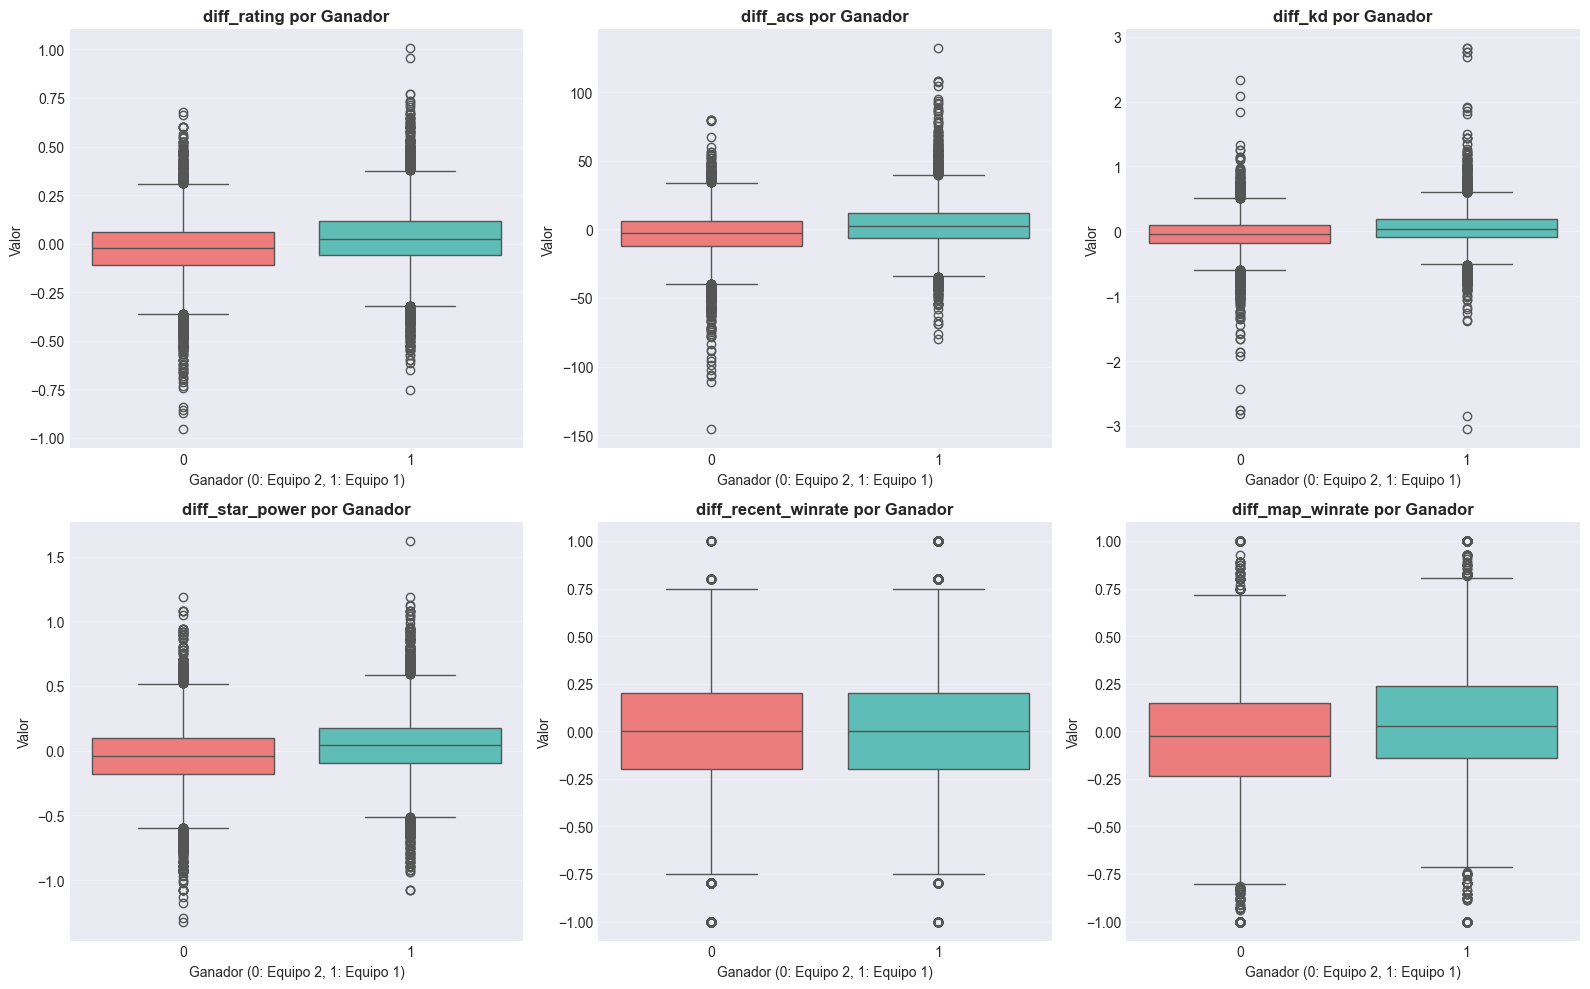

In [17]:
# Visualizar cómo se distribuyen las variables clave según el ganador
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, var in enumerate(key_performance_vars):
    sns.boxplot(data=df, x='winner', y=var, ax=axes[idx], palette=['#ff6b6b', '#4ecdc4'])
    axes[idx].set_title(f'{var} por Ganador', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Ganador (0: Equipo 2, 1: Equipo 1)')
    axes[idx].set_ylabel('Valor')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. Reducción de Dimensionalidad y Visualización

### 6.1 Análisis de Componentes Principales (PCA)

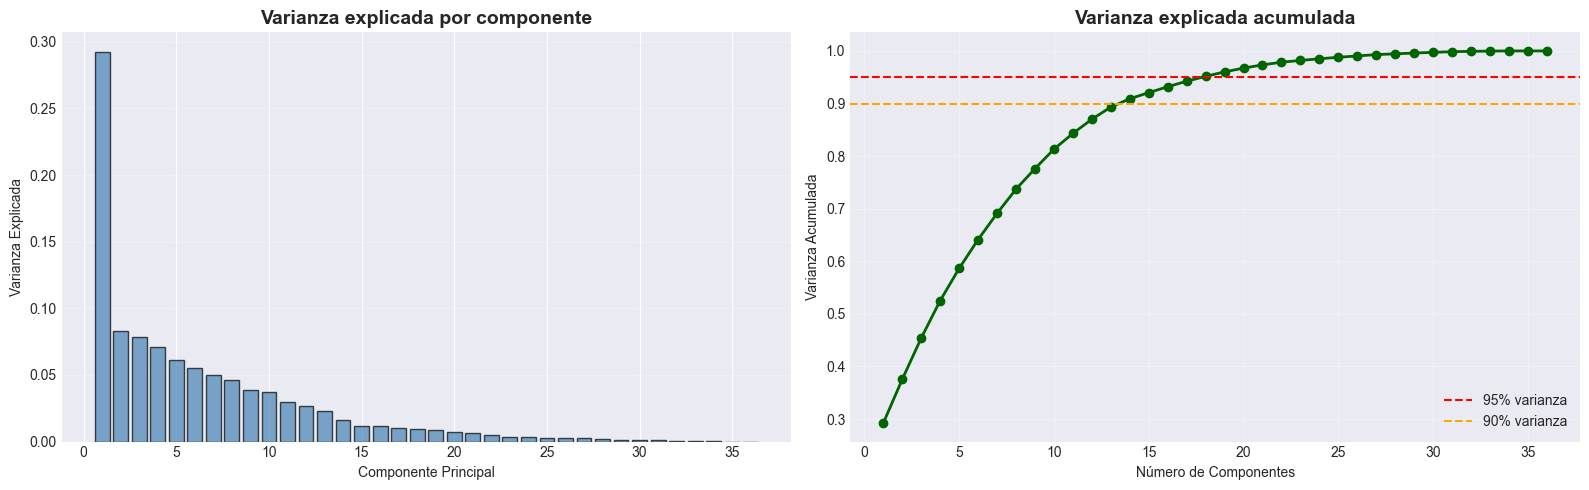

Análisis de componentes principales (PCA)
Características totales: 36
Componentes para 90% de varianza: 14
Componentes para 95% de varianza: 18
Varianza explicada (2 componentes): 37.57%
Varianza explicada (3 componentes): 45.41%


In [18]:
# Análisis de PCA: varianza explicada por componentes principales
# Normalización de variables continuas para PCA
scaler_viz = StandardScaler()
X_scaled = X.copy()
X_scaled[variables_to_scale] = scaler_viz.fit_transform(X[variables_to_scale])

# PCA completo sobre todas las componentes
pca_full = PCA()
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico 1: Varianza individual por componente
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Varianza explicada por componente', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Varianza acumulada
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
             marker='o', linewidth=2, color='darkgreen')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% varianza')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada')
axes[1].set_title('Varianza explicada acumulada', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen de componentes necesarias
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print("Análisis de componentes principales (PCA)")
print(f"Características totales: {X_scaled.shape[1]}")
print(f"Componentes para 90% de varianza: {n_components_90}")
print(f"Componentes para 95% de varianza: {n_components_95}")
print(f"Varianza explicada (2 componentes): {cumulative_variance[1]:.2%}")
print(f"Varianza explicada (3 componentes): {cumulative_variance[2]:.2%}")

### 6.2 Visualización 2D con PCA

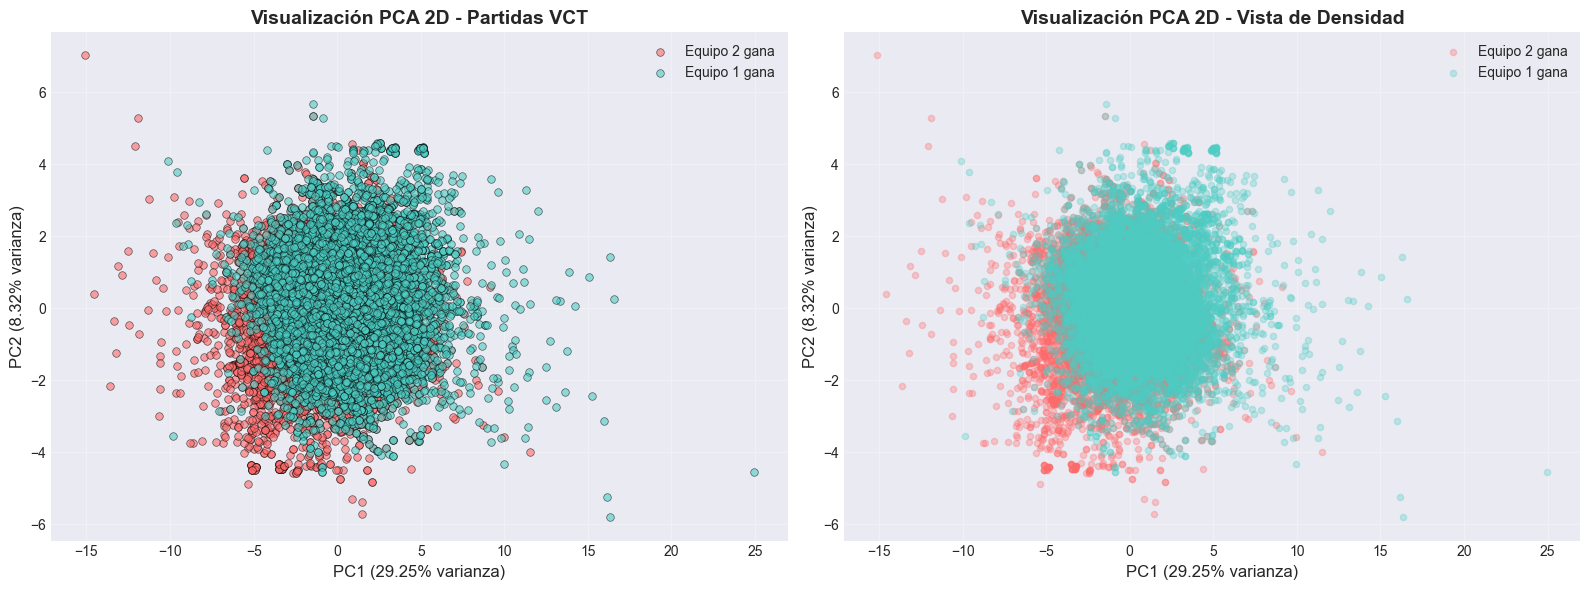


Varianza total explicada por 2 componentes: 37.57%


In [19]:
# Aplicar PCA con 2 componentes para visualización
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Crear DataFrame para visualización
pca_df = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df['winner'] = y.values

# Visualización 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter plot básico
for winner_class in [0, 1]:
    mask = pca_df['winner'] == winner_class
    label = f'Equipo {2 if winner_class == 0 else 1} gana'
    color = '#ff6b6b' if winner_class == 0 else '#4ecdc4'
    axes[0].scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
                   label=label, alpha=0.6, s=30, color=color, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} varianza)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} varianza)', fontsize=12)
axes[0].set_title('Visualización PCA 2D - Partidas VCT', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Density plot
for winner_class in [0, 1]:
    mask = pca_df['winner'] == winner_class
    label = f'Equipo {2 if winner_class == 0 else 1} gana'
    color = '#ff6b6b' if winner_class == 0 else '#4ecdc4'
    axes[1].scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
                   label=label, alpha=0.3, s=20, color=color)

axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} varianza)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} varianza)', fontsize=12)
axes[1].set_title('Visualización PCA 2D - Vista de Densidad', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVarianza total explicada por 2 componentes: {pca_2d.explained_variance_ratio_.sum():.2%}")

### 6.3 Contribución de las Variables a las Componentes Principales

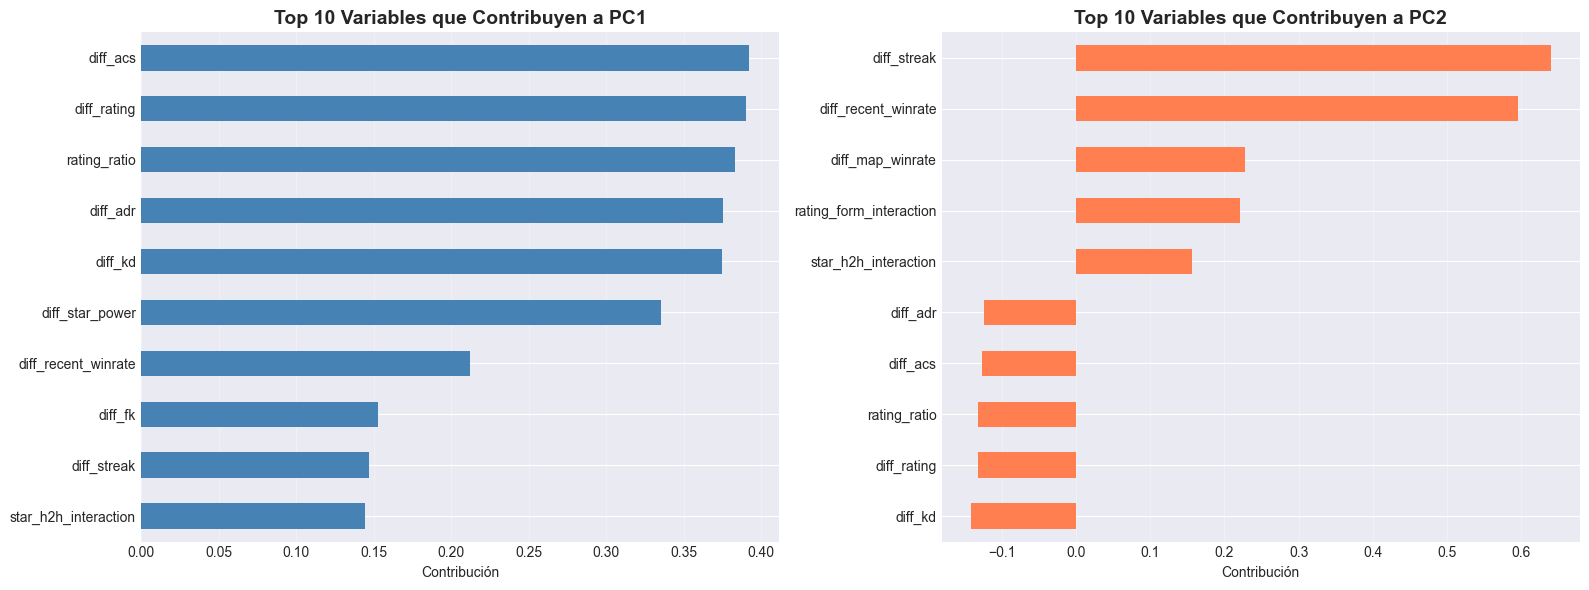

VARIABLES MÁS IMPORTANTES EN CADA COMPONENTE

PC1 (variables con mayor peso absoluto):
diff_acs                0.3920
diff_rating             0.3901
rating_ratio            0.3830
diff_adr                0.3751
diff_kd                 0.3744
diff_star_power         0.3351
diff_recent_winrate     0.2124
diff_fk                 0.1527
diff_streak             0.1469
star_h2h_interaction    0.1445
Name: PC1, dtype: float64

PC2 (variables con mayor peso absoluto):
diff_streak                0.6400
diff_recent_winrate        0.5952
diff_map_winrate           0.2279
rating_form_interaction    0.2206
star_h2h_interaction       0.1566
diff_kd                    0.1417
diff_rating                0.1315
rating_ratio               0.1312
diff_acs                   0.1268
diff_adr                   0.1242
Name: PC2, dtype: float64


In [20]:
# Analizar las contribuciones de las variables a PC1 y PC2
components_df = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=X_scaled.columns
)

# Top 10 variables con mayor contribución a PC1
top_pc1 = components_df['PC1'].abs().sort_values(ascending=False).head(10)
# Top 10 variables con mayor contribución a PC2
top_pc2 = components_df['PC2'].abs().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PC1
components_df.loc[top_pc1.index, 'PC1'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 10 Variables que Contribuyen a PC1', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Contribución')
axes[0].grid(axis='x', alpha=0.3)

# PC2
components_df.loc[top_pc2.index, 'PC2'].sort_values().plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 10 Variables que Contribuyen a PC2', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Contribución')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("VARIABLES MÁS IMPORTANTES EN CADA COMPONENTE")
print("\nPC1 (variables con mayor peso absoluto):")
print(top_pc1)
print("\nPC2 (variables con mayor peso absoluto):")
print(top_pc2)

### 6.4 t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [21]:
print("Aplicando t-SNE (n_components=2, perplexity=30)")

tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000, verbose=0)
X_tsne_2d = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=X_tsne_2d, columns=['t-SNE1', 't-SNE2'])
tsne_df['winner'] = y.values

Aplicando t-SNE (n_components=2, perplexity=30)


### 6.5 Visualización 2D con t-SNE

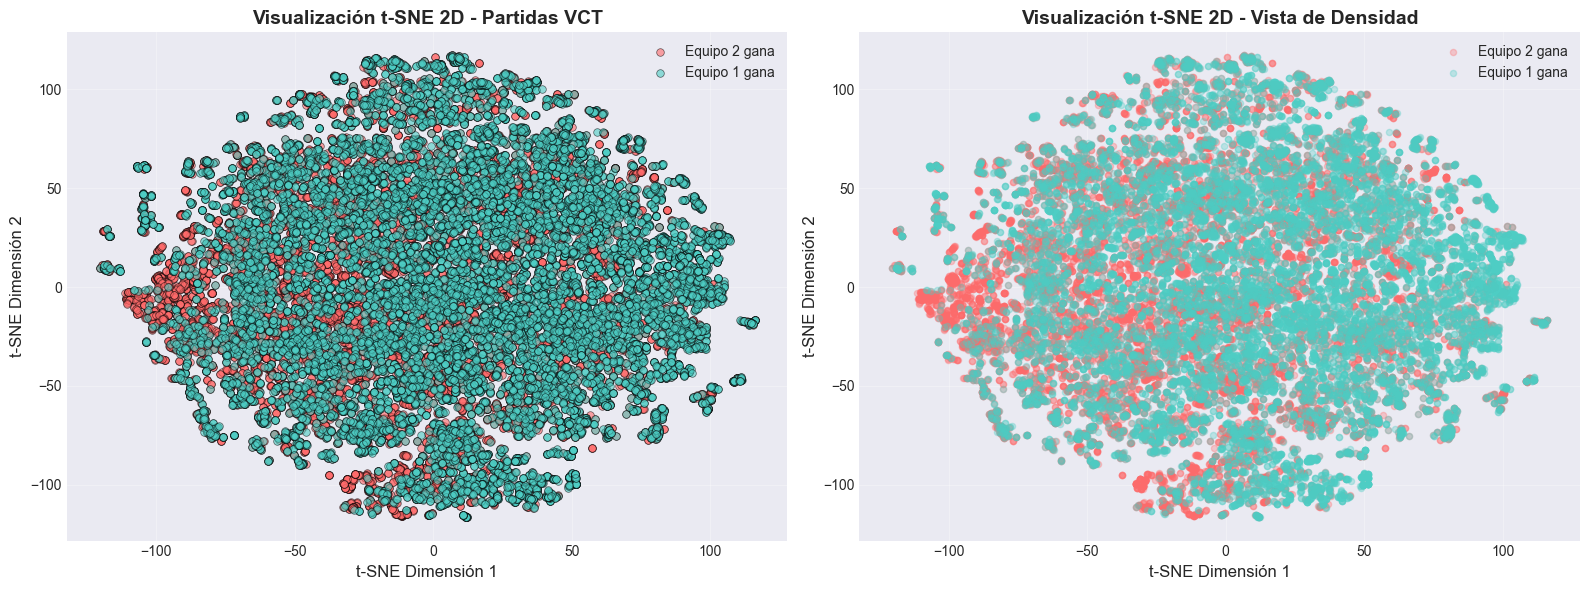

In [22]:
# Visualización t-SNE en 2D para reducción dimensional no lineal
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter plot con separación por clase
for winner_class in [0, 1]:
    mask = tsne_df['winner'] == winner_class
    label = f'Equipo {2 if winner_class == 0 else 1} gana'
    color = '#ff6b6b' if winner_class == 0 else '#4ecdc4'
    axes[0].scatter(tsne_df[mask]['t-SNE1'], tsne_df[mask]['t-SNE2'], 
                   label=label, alpha=0.6, s=30, color=color, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('t-SNE Dimensión 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimensión 2', fontsize=12)
axes[0].set_title('Visualización t-SNE 2D - Partidas VCT', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Vista de densidad con mayor transparencia
for winner_class in [0, 1]:
    mask = tsne_df['winner'] == winner_class
    label = f'Equipo {2 if winner_class == 0 else 1} gana'
    color = '#ff6b6b' if winner_class == 0 else '#4ecdc4'
    axes[1].scatter(tsne_df[mask]['t-SNE1'], tsne_df[mask]['t-SNE2'], 
                   label=label, alpha=0.3, s=20, color=color)

axes[1].set_xlabel('t-SNE Dimensión 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimensión 2', fontsize=12)
axes[1].set_title('Visualización t-SNE 2D - Vista de Densidad', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.6 Comparación PCA vs t-SNE

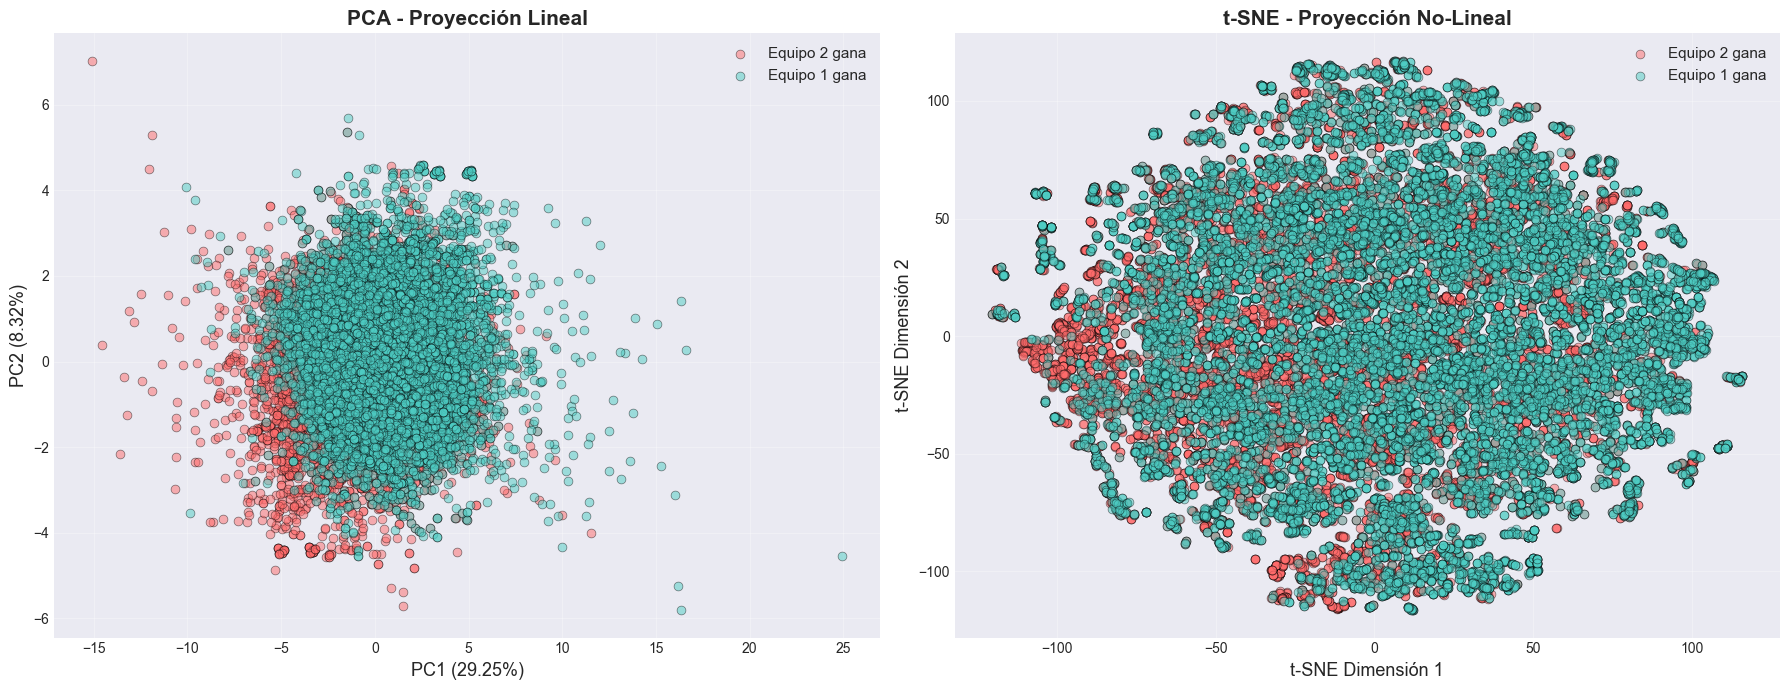

In [23]:
# Comparación lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA
for winner_class in [0, 1]:
    mask = pca_df['winner'] == winner_class
    label = f'Equipo {2 if winner_class == 0 else 1} gana'
    color = '#ff6b6b' if winner_class == 0 else '#4ecdc4'
    axes[0].scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
                   label=label, alpha=0.5, s=40, color=color, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})', fontsize=13)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})', fontsize=13)
axes[0].set_title('PCA - Proyección Lineal', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# t-SNE
for winner_class in [0, 1]:
    mask = tsne_df['winner'] == winner_class
    label = f'Equipo {2 if winner_class == 0 else 1} gana'
    color = '#ff6b6b' if winner_class == 0 else '#4ecdc4'
    axes[1].scatter(tsne_df[mask]['t-SNE1'], tsne_df[mask]['t-SNE2'], 
                   label=label, alpha=0.5, s=40, color=color, edgecolors='black', linewidth=0.5)

axes[1].set_xlabel('t-SNE Dimensión 1', fontsize=13)
axes[1].set_ylabel('t-SNE Dimensión 2', fontsize=13)
axes[1].set_title('t-SNE - Proyección No-Lineal', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 7. Entrenamiento y Optimización de Modelos

### 7.1 División de Datos y Preparación

In [24]:
# División Train-Test 80/20 respetando orden temporal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False
)

# Escalado de variables continuas (fit en train, transform en train y test)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[variables_to_scale] = scaler.fit_transform(X_train[variables_to_scale])
X_test_scaled[variables_to_scale] = scaler.transform(X_test[variables_to_scale])

X_train = X_train_scaled
X_test = X_test_scaled

print("División train-test (80/20, orden temporal preservado)")
print(f"Train: {X_train.shape[0]} partidas")
print(f"Test: {X_test.shape[0]} partidas")
print(f"\nVariables totales: {X_train.shape[1]}")
print(f"Variables escaladas: {len(variables_to_scale)}")
print(f"Variables binarias: {X_train.shape[1] - len(variables_to_scale)}")

División train-test (80/20, orden temporal preservado)
Train: 24938 partidas
Test: 6235 partidas

Variables totales: 36
Variables escaladas: 16
Variables binarias: 20


### 7.2 Definición de Funciones de Optimización

In [25]:
# Funciones para optimizar y entrenar modelos con validación temporal
def objective(trial, model_name, X, y):
    """Función objetivo de Optuna con TimeSeriesSplit."""
    cv = TimeSeriesSplit(n_splits=5)

    if model_name == 'LogisticRegression':
        C = trial.suggest_float('C', 0.01, 10, log=True)
        penalty = trial.suggest_categorical('penalty', ['l2'])
        model = LogisticRegression(C=C, penalty=penalty, solver='lbfgs', max_iter=1000)

    elif model_name == 'LDA':
        solver = trial.suggest_categorical('solver', ['svd', 'lsqr'])
        model = LinearDiscriminantAnalysis(solver=solver)

    elif model_name == 'LinearSVM':
        C = trial.suggest_float('C', 0.01, 10, log=True)
        model = LinearSVC(C=C, max_iter=2000, dual=True, random_state=42)

    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_split=min_samples_split, random_state=42, n_jobs=-1
        )

    elif model_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = GradientBoostingClassifier(
            n_estimators=n_estimators, learning_rate=learning_rate,
            max_depth=max_depth, random_state=42
        )

    elif model_name == 'MLP':
        hidden_layer_sizes = trial.suggest_categorical(
            'hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]
        )
        alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
        learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)
        model = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=500,
            early_stopping=True,
            random_state=42
        )

    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()

def run_optimization(model_name, n_trials=20):
    """Ejecuta la búsqueda de hiperparámetros y devuelve modelo y métricas de CV."""
    print(f"Optimizando {model_name}...")
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective(trial, model_name, X_train, y_train),
                   n_trials=n_trials, show_progress_bar=False, n_jobs=-1)
    print(f"   Mejores parámetros: {study.best_params}")
    print(f"   Mejor accuracy CV: {study.best_value:.4f}\n")

    cv = TimeSeriesSplit(n_splits=5)

    if model_name == 'LogisticRegression':
        best_model = LogisticRegression(**study.best_params, solver='lbfgs', max_iter=1000)
    elif model_name == 'LDA':
        best_model = LinearDiscriminantAnalysis(**study.best_params)
    elif model_name == 'LinearSVM':
        best_model = LinearSVC(**study.best_params, max_iter=2000, dual=True, random_state=42)
    elif model_name == 'RandomForest':
        best_model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
    elif model_name == 'GradientBoosting':
        best_model = GradientBoostingClassifier(**study.best_params, random_state=42)
    elif model_name == 'MLP':
        best_model = MLPClassifier(**study.best_params, max_iter=500, early_stopping=True, random_state=42)

    cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_precision = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='precision', n_jobs=-1)
    cv_recall = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
    cv_f1 = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

    cv_metrics = {
        'accuracy': cv_accuracy,
        'precision': cv_precision,
        'recall': cv_recall,
        'f1': cv_f1
    }

    print("Entrenando modelo final con todos los datos de entrenamiento...")
    best_model.fit(X_train, y_train)

    return study.best_params, study.best_value, study.best_trial, cv_metrics, best_model

### 7.3 Entrenamiento y Optimización con Optuna

OPTIMIZACIÓN DE HIPERPARÁMETROS CON VALIDACIÓN CRUZADA TEMPORAL
Modelos: ['LogisticRegression', 'LDA', 'LinearSVM', 'RandomForest', 'GradientBoosting', 'MLP']
Validación: TimeSeriesSplit (5 folds)
Muestras de entrenamiento: 24938
Cargando parámetros previos desde 'optimized_params.json'...
Modelos con parámetros cargados: ['GradientBoosting', 'LDA', 'LinearSVM', 'LogisticRegression', 'MLP', 'RandomForest']
Cargando modelos entrenados desde 'trained_models.pkl'...
Modelos cargados: ['LogisticRegression', 'LDA', 'LinearSVM', 'RandomForest', 'GradientBoosting', 'MLP']
Todos los modelos ya disponen de parámetros optimizados.
No hay modelos que requieran entrenamiento nuevo.


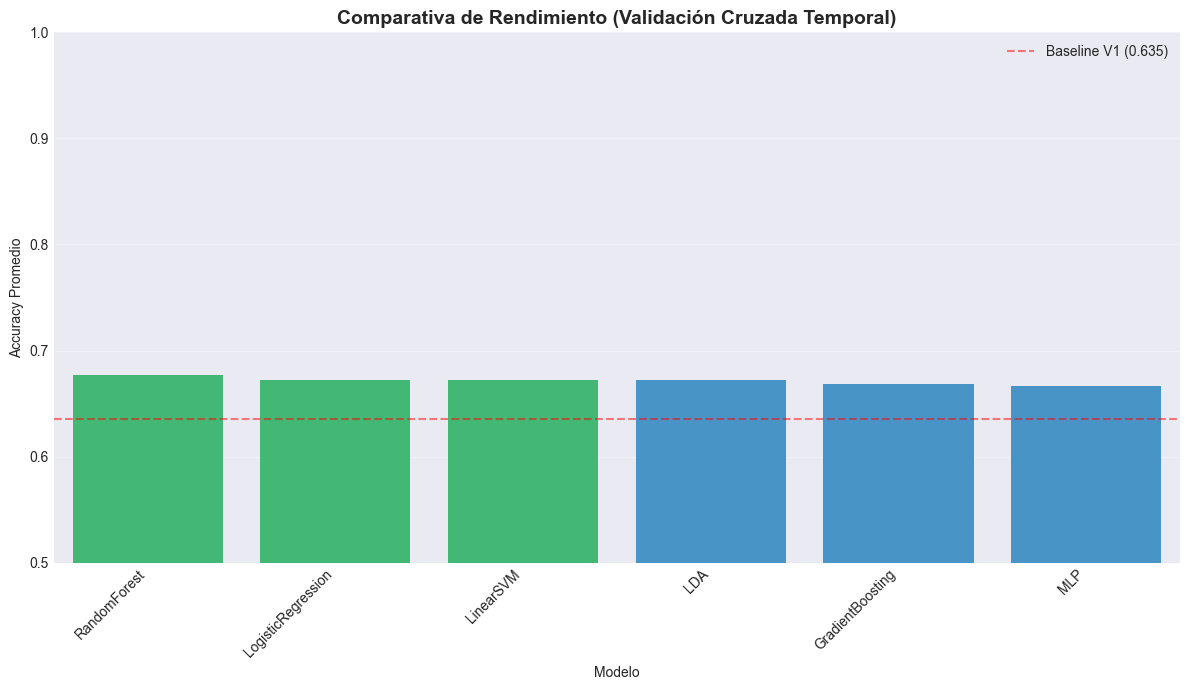


Ranking de modelos por accuracy CV
                    CV Accuracy
RandomForest             0.6765
LogisticRegression       0.6724
LinearSVM                0.6724
LDA                      0.6721
GradientBoosting         0.6684
MLP                      0.6670

Mejores 3 modelos: RandomForest, LogisticRegression, LinearSVM
Accuracy máxima: 0.6765
Accuracy promedio: 0.6715


In [26]:
# Pipeline de optimización de hiperparámetros con Optuna
results = {}
best_models_params = {}
cv_scores_by_model = {}
trained_models_dict = {}  # Diccionario global para almacenar modelos entrenados

# Configuración de entrenamiento: 'none', 'linear', 'nonlinear', 'all'
RETRAIN_MODE = 'none'

LINEAR_MODELS = ['LogisticRegression', 'LDA', 'LinearSVM']
NONLINEAR_MODELS = ['RandomForest', 'GradientBoosting', 'MLP']
models_to_test = LINEAR_MODELS + NONLINEAR_MODELS

print("OPTIMIZACIÓN DE HIPERPARÁMETROS CON VALIDACIÓN CRUZADA TEMPORAL")
print("Modelos:", models_to_test)
print("Validación: TimeSeriesSplit (5 folds)")
print(f"Muestras de entrenamiento: {X_train.shape[0]}")

def save_params_incremental(model_name, best_params, best_score, cv_metrics, trained_model=None):
    """
    Guarda parámetros óptimos, métricas de CV y el modelo entrenado.
    - optimized_params.json: hiperparámetros y métricas
    - trained_models.pkl: modelos entrenados listos para predicción
    """
    global trained_models_dict
    timestamp = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')

    # Carga o inicialización de archivo JSON
    if os.path.exists('optimized_params.json'):
        with open('optimized_params.json', 'r') as f:
            data = json.load(f)
    else:
        data = {
            'best_params': {},
            'cv_metrics': {},
            'cv_accuracy': {},
            'timestamp': {}
        }

    # Actualización de datos
    data['best_params'][model_name] = best_params
    data['cv_metrics'][model_name] = {
        'accuracy': cv_metrics['accuracy'].tolist() if isinstance(cv_metrics['accuracy'], np.ndarray) else cv_metrics['accuracy'],
        'precision': cv_metrics['precision'].tolist() if isinstance(cv_metrics['precision'], np.ndarray) else cv_metrics['precision'],
        'recall': cv_metrics['recall'].tolist() if isinstance(cv_metrics['recall'], np.ndarray) else cv_metrics['recall'],
        'f1': cv_metrics['f1'].tolist() if isinstance(cv_metrics['f1'], np.ndarray) else cv_metrics['f1']
    }
    data['cv_accuracy'][model_name] = best_score
    data['timestamp'] = timestamp

    # Guardado de JSON
    with open('optimized_params.json', 'w') as f:
        json.dump(data, f, indent=4)
    print(f"[{timestamp}] Parámetros guardados en 'optimized_params.json'")

    # Guardado de modelo entrenado
    if trained_model is not None:
        if os.path.exists('trained_models.pkl'):
            with open('trained_models.pkl', 'rb') as f:
                trained_models_dict = pickle.load(f)
        trained_models_dict[model_name] = trained_model
        with open('trained_models.pkl', 'wb') as f:
            pickle.dump(trained_models_dict, f)
        print(f"Modelo '{model_name}' guardado en 'trained_models.pkl'")

# Selección de modelos según modo de reentrenamiento
if RETRAIN_MODE == 'all':
    models_to_train = models_to_test
elif RETRAIN_MODE == 'linear':
    models_to_train = LINEAR_MODELS
elif RETRAIN_MODE == 'nonlinear':
    models_to_train = NONLINEAR_MODELS
elif RETRAIN_MODE == 'none':
    models_to_train = []
else:
    raise ValueError("RETRAIN_MODE inválido")

# Carga de parámetros previos si existen
loaded_models = set()
cv_metrics_by_model = {}
if os.path.exists('optimized_params.json'):
    print("Cargando parámetros previos desde 'optimized_params.json'...")
    with open('optimized_params.json', 'r') as f:
        data = json.load(f)
    best_models_params = data.get('best_params', {})
    cv_metrics_data = data.get('cv_metrics', {})
    cv_metrics_by_model = {
        k: {
            'accuracy': np.array(v.get('accuracy', [])),
            'precision': np.array(v.get('precision', [])),
            'recall': np.array(v.get('recall', [])),
            'f1': np.array(v.get('f1', []))
        }
        for k, v in cv_metrics_data.items()
    }
    results = data.get('cv_accuracy', {})
    loaded_models = set(best_models_params.keys())
    print("Modelos con parámetros cargados:", sorted(loaded_models))
else:
    best_models_params = {}
    cv_metrics_by_model = {}
    results = {}

# Carga de modelos entrenados previos
if os.path.exists('trained_models.pkl'):
    print("Cargando modelos entrenados desde 'trained_models.pkl'...")
    with open('trained_models.pkl', 'rb') as f:
        trained_models_dict = pickle.load(f)
    print(f"Modelos cargados: {list(trained_models_dict.keys())}")
else:
    print("No se encontró 'trained_models.pkl'. Se usará un diccionario vacío.")

# En modo 'none', solo entrenar modelos faltantes
if RETRAIN_MODE == 'none':
    missing_models = set(models_to_test) - loaded_models
    models_to_train = list(missing_models)
    if missing_models:
        print("Modelos faltantes que se reentrenarán:", sorted(missing_models))
    else:
        print("Todos los modelos ya disponen de parámetros optimizados.")

# Bucle de entrenamiento y optimización con Optuna
if models_to_train:
    print("Inicio de la optimización de modelos")
    for i, model_name in enumerate(models_to_train, 1):
        print(f"[{i}/{len(models_to_train)}] {model_name}")
        best_params, best_score, _, cv_metrics, trained_model = run_optimization(model_name, n_trials=30)
        results[model_name] = best_score
        best_models_params[model_name] = best_params
        cv_metrics_by_model[model_name] = cv_metrics
        save_params_incremental(model_name, best_params, best_score, cv_metrics, trained_model)
        print(f"Modelo '{model_name}' optimizado. Accuracy CV: {best_score:.4f}\n")
    print("Optimización completada.")
else:
    print("No hay modelos que requieran entrenamiento nuevo.")

# Visualización comparativa de rendimiento en CV
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['CV Accuracy'])
results_df = results_df.sort_values(by='CV Accuracy', ascending=False)

plt.figure(figsize=(12, 7))
colors = ['#2ecc71' if i < 3 else '#3498db' for i in range(len(results_df))]
sns.barplot(x=results_df.index, y=results_df['CV Accuracy'], palette=colors)
plt.title('Comparativa de Rendimiento (Validación Cruzada Temporal)', fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy Promedio')
plt.xlabel('Modelo')
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0.635, color='r', linestyle='--', label='Baseline V1 (0.635)', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRanking de modelos por accuracy CV")
print(results_df)
print(f"\nMejores 3 modelos: {', '.join(results_df.head(3).index.tolist())}")
print(f"Accuracy máxima: {results_df['CV Accuracy'].max():.4f}")
print(f"Accuracy promedio: {results_df['CV Accuracy'].mean():.4f}")

### 7.4 Resultados de Hiperparámetros Optimizados

In [27]:
# Resumen de hiperparámetros optimizados por modelo

if 'best_models_params' in locals() and len(best_models_params) > 0:
    print("Hiperparámetros optimizados")
    for model_name, params in best_models_params.items():
        model_type = "Lineal" if model_name in LINEAR_MODELS else "No lineal"
        cv_acc = results.get(model_name, 0)
        print(f"\n{model_type} - {model_name} (CV Accuracy: {cv_acc:.4f})")
        for param_name, param_value in params.items():
            print(f"  - {param_name}: {param_value}")
    print(f"\nTotal de modelos optimizados: {len(best_models_params)}")
    print("Parámetros guardados en 'optimized_params.json'")
else:
    print("No hay parámetros optimizados disponibles.")
    print("Ejecuta la celda de entrenamiento/optimización anterior.")

Hiperparámetros optimizados

Lineal - LogisticRegression (CV Accuracy: 0.6724)
  - C: 9.912348063197733
  - penalty: l2

Lineal - LDA (CV Accuracy: 0.6721)
  - solver: svd

Lineal - LinearSVM (CV Accuracy: 0.6724)
  - C: 3.339326537757693

No lineal - RandomForest (CV Accuracy: 0.6765)
  - n_estimators: 178
  - max_depth: 18
  - min_samples_split: 10

No lineal - GradientBoosting (CV Accuracy: 0.6684)
  - n_estimators: 266
  - learning_rate: 0.020690970741884973
  - max_depth: 3

No lineal - MLP (CV Accuracy: 0.6670)
  - hidden_layer_sizes: [100]
  - alpha: 1.3494915412541108e-05
  - learning_rate_init: 0.0011456674816890768

Total de modelos optimizados: 6
Parámetros guardados en 'optimized_params.json'


### 7.5 Scores Detallados por Fold de Validación Cruzada

Métricas de validación cruzada (promedio de 5 folds)
     Tipo             Modelo        Accuracy       Precision          Recall        F1-Score
No lineal       RandomForest 0.6765 ± 0.0347 0.6876 ± 0.0349 0.6604 ± 0.0314 0.6736 ± 0.0323
   Lineal LogisticRegression 0.6724 ± 0.0343 0.6831 ± 0.0337 0.6564 ± 0.0341 0.6694 ± 0.0329
   Lineal          LinearSVM 0.6724 ± 0.0327 0.6838 ± 0.0324 0.6542 ± 0.0316 0.6686 ± 0.0314
   Lineal                LDA 0.6721 ± 0.0318 0.6830 ± 0.0312 0.6554 ± 0.0323 0.6688 ± 0.0308
No lineal   GradientBoosting 0.6684 ± 0.0353 0.6833 ± 0.0364 0.6409 ± 0.0332 0.6614 ± 0.0341
No lineal                MLP 0.6670 ± 0.0373 0.6838 ± 0.0303 0.6300 ± 0.0729 0.6546 ± 0.0518

Scores de ACCURACY por fold
     Tipo             Modelo Fold 1 Fold 2 Fold 3 Fold 4 Fold 5  Media    Std
No lineal       RandomForest 0.6882 0.6956 0.7178 0.6157 0.6653 0.6765 0.0347
   Lineal LogisticRegression 0.6872 0.6858 0.7122 0.6102 0.6667 0.6724 0.0343
   Lineal          LinearSVM 0.68

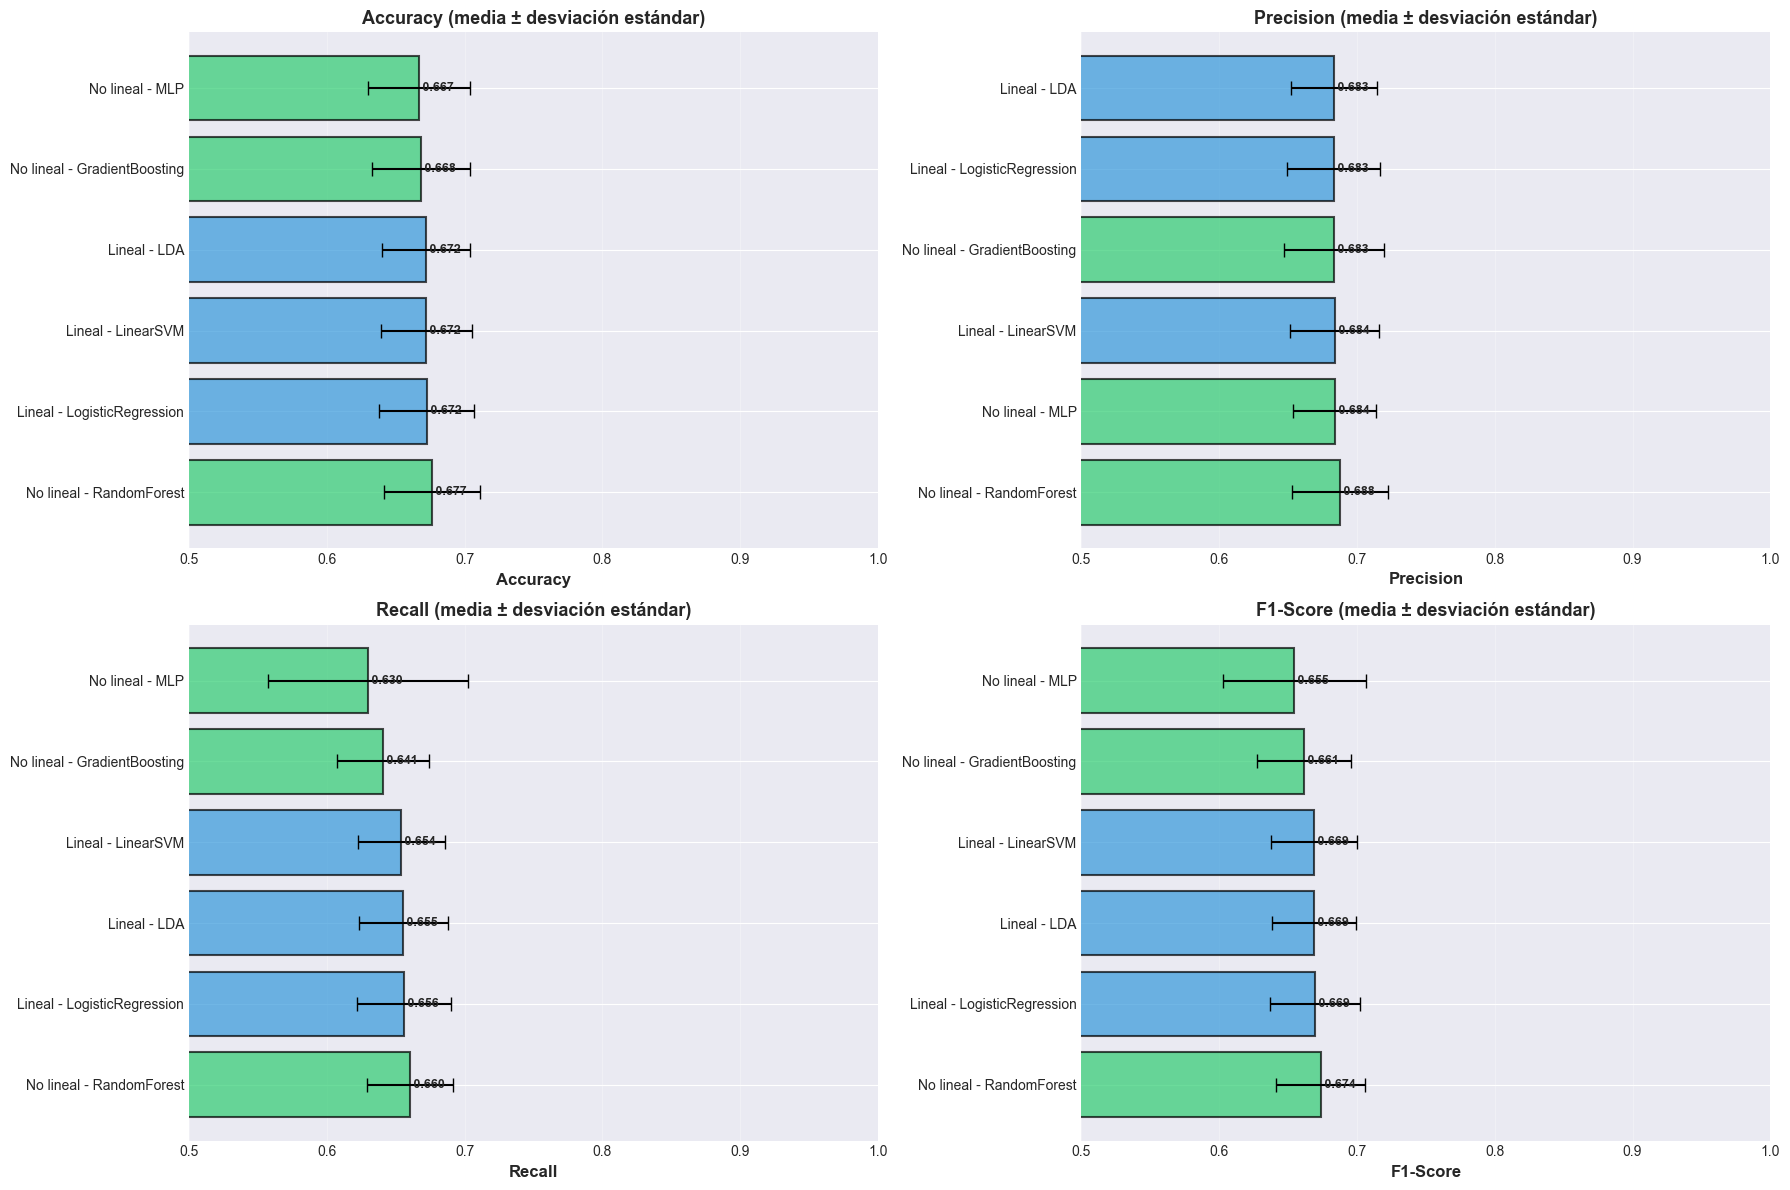

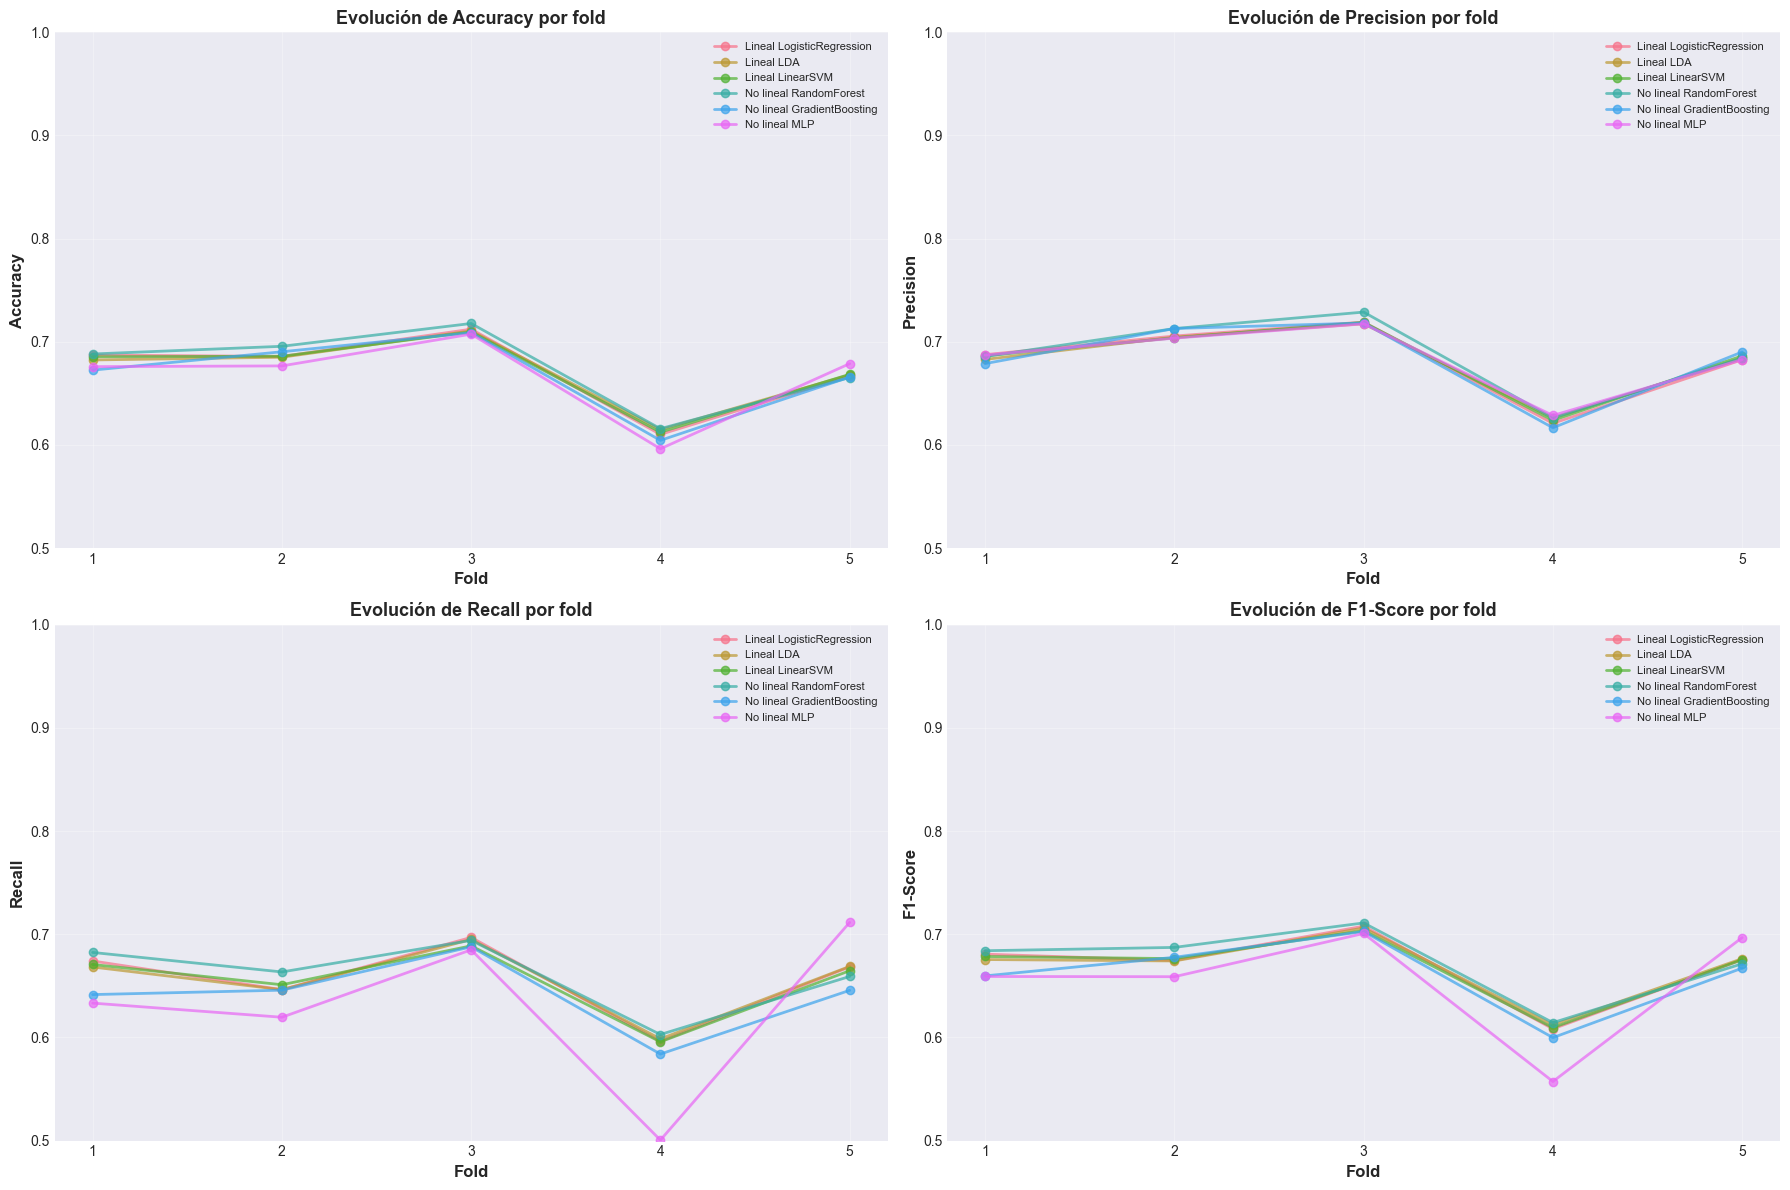

In [28]:
# Métricas detalladas de validación cruzada (TimeSeriesSplit)
if 'cv_metrics_by_model' in locals() and len(cv_metrics_by_model) > 0:
    print("Métricas de validación cruzada (promedio de 5 folds)")

    summary_data = []
    for model_name, metrics in cv_metrics_by_model.items():
        model_type = "Lineal" if model_name in LINEAR_MODELS else "No lineal"
        row = {
            'Tipo': model_type,
            'Modelo': model_name,
            'Accuracy': f"{metrics['accuracy'].mean():.4f} ± {metrics['accuracy'].std():.4f}",
            'Precision': f"{metrics['precision'].mean():.4f} ± {metrics['precision'].std():.4f}",
            'Recall': f"{metrics['recall'].mean():.4f} ± {metrics['recall'].std():.4f}",
            'F1-Score': f"{metrics['f1'].mean():.4f} ± {metrics['f1'].std():.4f}"
        }
        summary_data.append(row)

    df_summary = pd.DataFrame(summary_data)
    df_summary['_acc_sort'] = df_summary['Accuracy'].str.split(' ').str[0].astype(float)
    df_summary = df_summary.sort_values('_acc_sort', ascending=False).drop('_acc_sort', axis=1)
    print(df_summary.to_string(index=False))
    print()

    # Detalle fold a fold por métrica
    for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
        print(f"Scores de {metric_name.upper()} por fold")
        cv_data = []
        for model_name, metrics in cv_metrics_by_model.items():
            model_type = "Lineal" if model_name in LINEAR_MODELS else "No lineal"
            scores = metrics[metric_name]
            row = {
                'Tipo': model_type,
                'Modelo': model_name,
                'Fold 1': f"{scores[0]:.4f}",
                'Fold 2': f"{scores[1]:.4f}",
                'Fold 3': f"{scores[2]:.4f}",
                'Fold 4': f"{scores[3]:.4f}",
                'Fold 5': f"{scores[4]:.4f}",
                'Media': f"{scores.mean():.4f}",
                'Std': f"{scores.std():.4f}"
            }
            cv_data.append(row)
        df_cv = pd.DataFrame(cv_data)
        df_cv['_sort'] = df_cv['Media'].astype(float)
        df_cv = df_cv.sort_values('_sort', ascending=False).drop('_sort', axis=1)
        print(df_cv.to_string(index=False))
        print()

    # Visualizaciones resumen de métricas
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    metrics_names = {
        'accuracy': 'Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
        'f1': 'F1-Score'
    }

    for idx, (metric_key, metric_label) in enumerate(metrics_names.items()):
        ax = axes[idx // 2, idx % 2]
        models = []
        means = []
        stds = []
        colors = []
        for model_name, metrics in sorted(cv_metrics_by_model.items(),
                                         key=lambda x: x[1][metric_key].mean(),
                                         reverse=True):
            model_type = "Lineal" if model_name in LINEAR_MODELS else "No lineal"
            models.append(f"{model_type} - {model_name}")
            means.append(metrics[metric_key].mean())
            stds.append(metrics[metric_key].std())
            colors.append('#3498db' if model_name in LINEAR_MODELS else '#2ecc71')
        ax.barh(models, means, xerr=stds, color=colors, alpha=0.7,
                edgecolor='black', linewidth=1.5, capsize=5)
        ax.set_xlabel(metric_label, fontsize=12, fontweight='bold')
        ax.set_title(f'{metric_label} (media ± desviación estándar)', fontsize=13, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        ax.set_xlim(0.5, 1.0)
        for i, mean in enumerate(means):
            ax.text(mean, i, f' {mean:.3f}', va='center', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    for idx, (metric_key, metric_label) in enumerate(metrics_names.items()):
        ax = axes[idx // 2, idx % 2]
        for model_name, metrics in cv_metrics_by_model.items():
            model_type = "Lineal" if model_name in LINEAR_MODELS else "No lineal"
            scores = metrics[metric_key]
            ax.plot(range(1, 6), scores, marker='o', linewidth=2,
                    label=f"{model_type} {model_name}", alpha=0.7)
        ax.set_xlabel('Fold', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric_label, fontsize=12, fontweight='bold')
        ax.set_title(f'Evolución de {metric_label} por fold', fontsize=13, fontweight='bold')
        ax.set_xticks(range(1, 6))
        ax.grid(alpha=0.3)
        ax.legend(loc='best', fontsize=8)
        ax.set_ylim(0.5, 1.0)
    plt.tight_layout()
    plt.show()
else:
    print("No hay métricas de validación cruzada disponibles.")
    print("Ejecuta primero la celda de entrenamiento.")

---

## 8. Evaluación Final de Modelos en Test Set

### 8.1 Evaluación detallada de cada modelo

In [29]:
# Evaluación de todos los modelos en el conjunto de test
trained_models = {}
all_predictions = {}
all_metrics_test = []

print("Evaluación de modelos en test set\n")

for model_name, params in best_models_params.items():
    print(f"\nModelo: {model_name}")
    
    # Instanciación del modelo con parámetros óptimos
    if model_name == 'LogisticRegression':
        model = LogisticRegression(**params, solver='lbfgs', max_iter=1000)
    elif model_name == 'LDA':
        model = LinearDiscriminantAnalysis(**params)
    elif model_name == 'LinearSVM':
        model = LinearSVC(**params, max_iter=2000, dual=True, random_state=42)
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    elif model_name == 'GradientBoosting':
        model = GradientBoostingClassifier(**params, random_state=42)
    elif model_name == 'MLP':
        model = MLPClassifier(**params, max_iter=500, early_stopping=True, random_state=42)
    
    # Entrenamiento en train completo
    model.fit(X_train, y_train)
    trained_models[model_name] = model
    
    # Predicción en test
    y_pred = model.predict(X_test)
    all_predictions[model_name] = y_pred
    
    # Reporte de métricas de CV (si están disponibles)
    if 'cv_metrics_by_model' in locals() and model_name in cv_metrics_by_model:
        metrics_cv = cv_metrics_by_model[model_name]
        print(f"Resultados en validación cruzada:")
        print(f"  Accuracy: {metrics_cv['accuracy'].mean():.4f} ± {metrics_cv['accuracy'].std():.4f}")
        print(f"  Precision: {metrics_cv['precision'].mean():.4f} ± {metrics_cv['precision'].std():.4f}")
        print(f"  Recall: {metrics_cv['recall'].mean():.4f} ± {metrics_cv['recall'].std():.4f}")
        print(f"  F1-Score: {metrics_cv['f1'].mean():.4f} ± {metrics_cv['f1'].std():.4f}")
    
    # Cálculo de métricas en test
    acc_test = accuracy_score(y_test, y_pred)
    prec_test = precision_score(y_test, y_pred, average='macro')
    rec_test = recall_score(y_test, y_pred, average='macro')
    f1_test = f1_score(y_test, y_pred, average='macro')
    
    print(f"\nResultados en test:")
    print(f"  Accuracy: {acc_test:.4f}")
    print(f"  Precision: {prec_test:.4f}")
    print(f"  Recall: {rec_test:.4f}")
    print(f"  F1-Score: {f1_test:.4f}")
    print(f"\n{classification_report(y_test, y_pred)}")
    
    # Almacenamiento de métricas para comparativa
    all_metrics_test.append({
        'Modelo': model_name,
        'Accuracy': acc_test,
        'Precision': prec_test,
        'Recall': rec_test,
        'F1-Score': f1_test
    })

# DataFrame con resultados finales ordenados por F1-Score
df_resultados_finales = pd.DataFrame(all_metrics_test).sort_values(by='F1-Score', ascending=False)

# Guardado de modelos entrenados
with open('trained_models.pkl', 'wb') as f:
    pickle.dump(trained_models, f)
print("\nModelos guardados en 'trained_models.pkl'")

Evaluación de modelos en test set


Modelo: LogisticRegression
Resultados en validación cruzada:
  Accuracy: 0.6724 ± 0.0343
  Precision: 0.6831 ± 0.0337
  Recall: 0.6564 ± 0.0341
  F1-Score: 0.6694 ± 0.0329

Resultados en test:
  Accuracy: 0.6603
  Precision: 0.6604
  Recall: 0.6604
  F1-Score: 0.6603

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      3149
           1       0.65      0.67      0.66      3086

    accuracy                           0.66      6235
   macro avg       0.66      0.66      0.66      6235
weighted avg       0.66      0.66      0.66      6235


Modelo: LDA
Resultados en validación cruzada:
  Accuracy: 0.6721 ± 0.0318
  Precision: 0.6830 ± 0.0312
  Recall: 0.6554 ± 0.0323
  F1-Score: 0.6688 ± 0.0308

Resultados en test:
  Accuracy: 0.6613
  Precision: 0.6616
  Recall: 0.6614
  F1-Score: 0.6612

              precision    recall  f1-score   support

           0       0.67      0.64      0.66      3149
    

### 8.2 Matrices de Confusión de Todos los Modelos

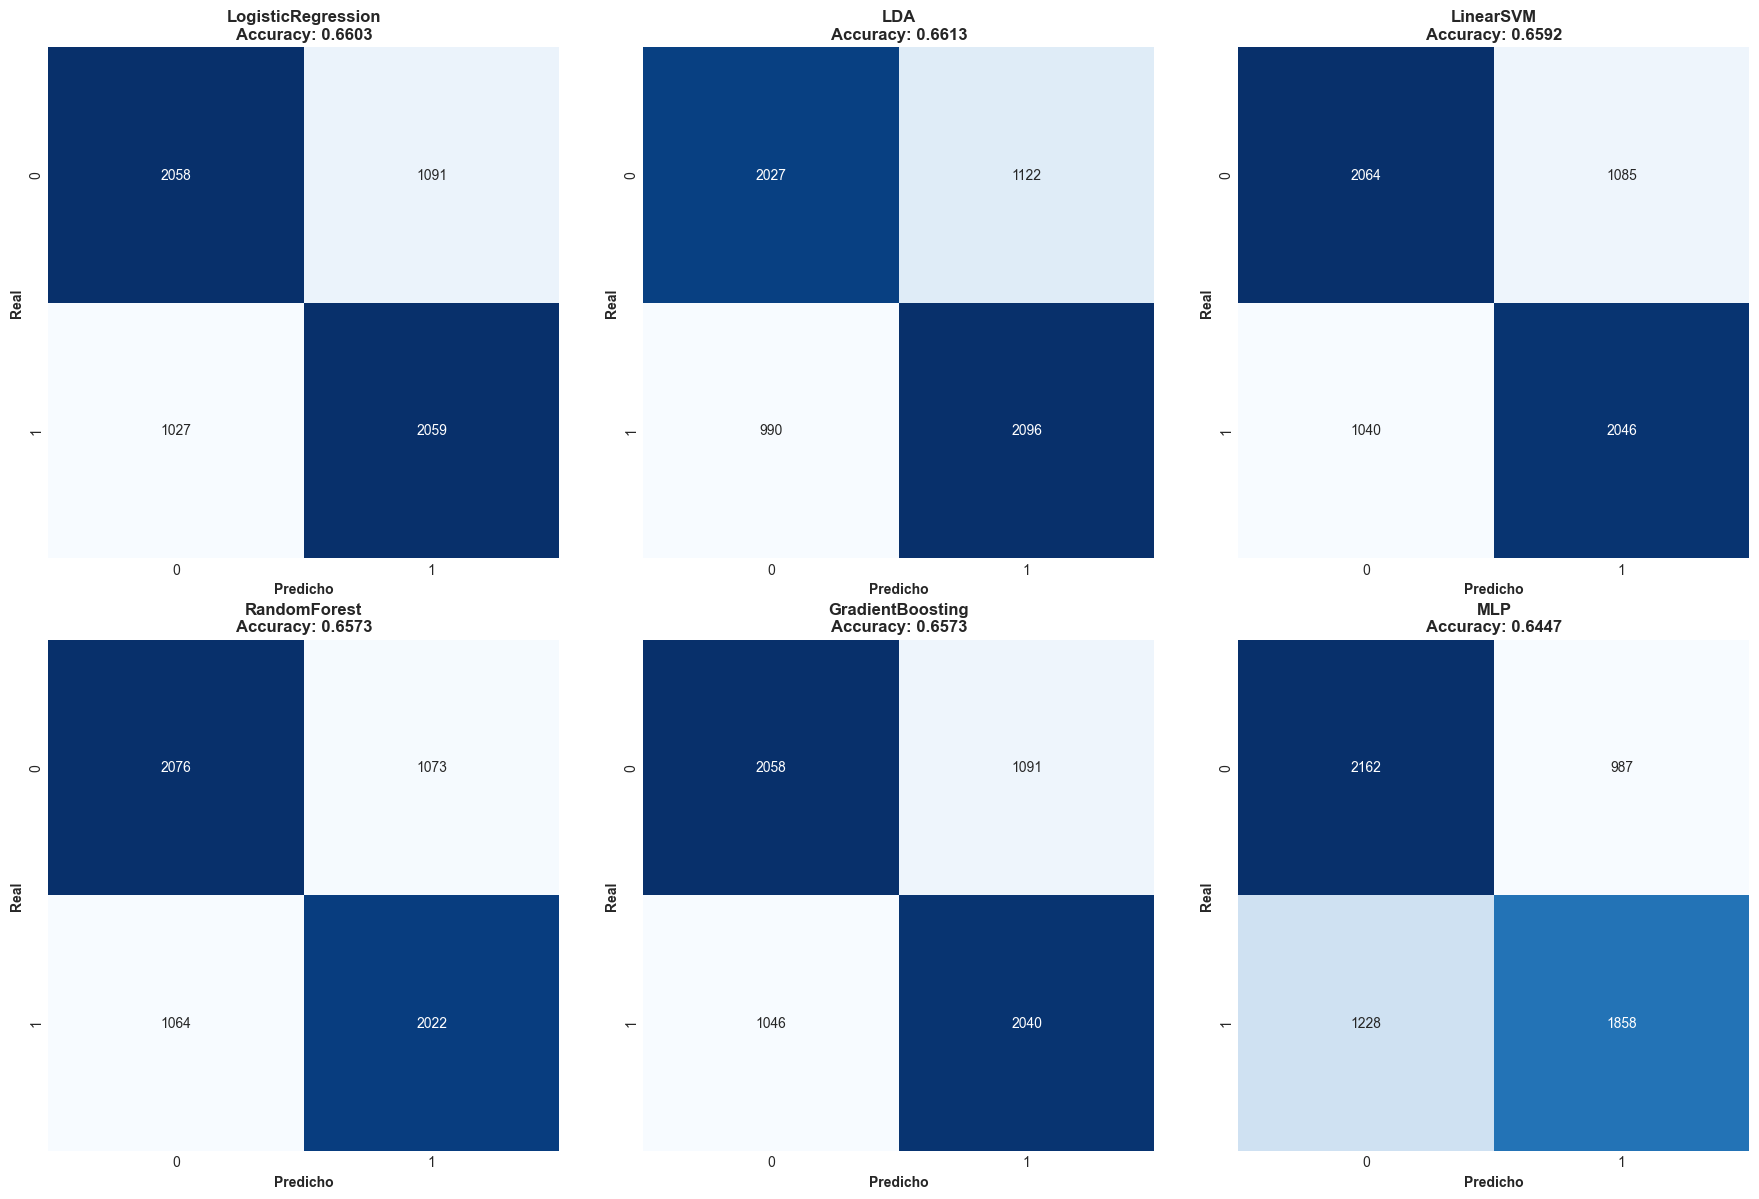

In [30]:
# Visualización de matrices de confusión para todos los modelos
n_models = len(trained_models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for i, (model_name, model) in enumerate(trained_models.items()):
    y_pred = all_predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    # Heatmap de la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar=False, square=True)
    axes[i].set_title(f'{model_name}\nAccuracy: {acc:.4f}', 
                     fontweight='bold', fontsize=12)
    axes[i].set_ylabel('Real', fontweight='bold')
    axes[i].set_xlabel('Predicho', fontweight='bold')

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 8.3 Tabla Resumen de Evaluación en Test

TABLA RESUMEN - EVALUACIÓN EN TEST

            Modelo  Accuracy  Precision  Recall  F1-Score
               LDA    0.6613     0.6616  0.6614    0.6612
LogisticRegression    0.6603     0.6604  0.6604    0.6603
         LinearSVM    0.6592     0.6592  0.6592    0.6592
  GradientBoosting    0.6573     0.6573  0.6573    0.6573
      RandomForest    0.6573     0.6572  0.6572    0.6572
               MLP    0.6447     0.6454  0.6443    0.6439


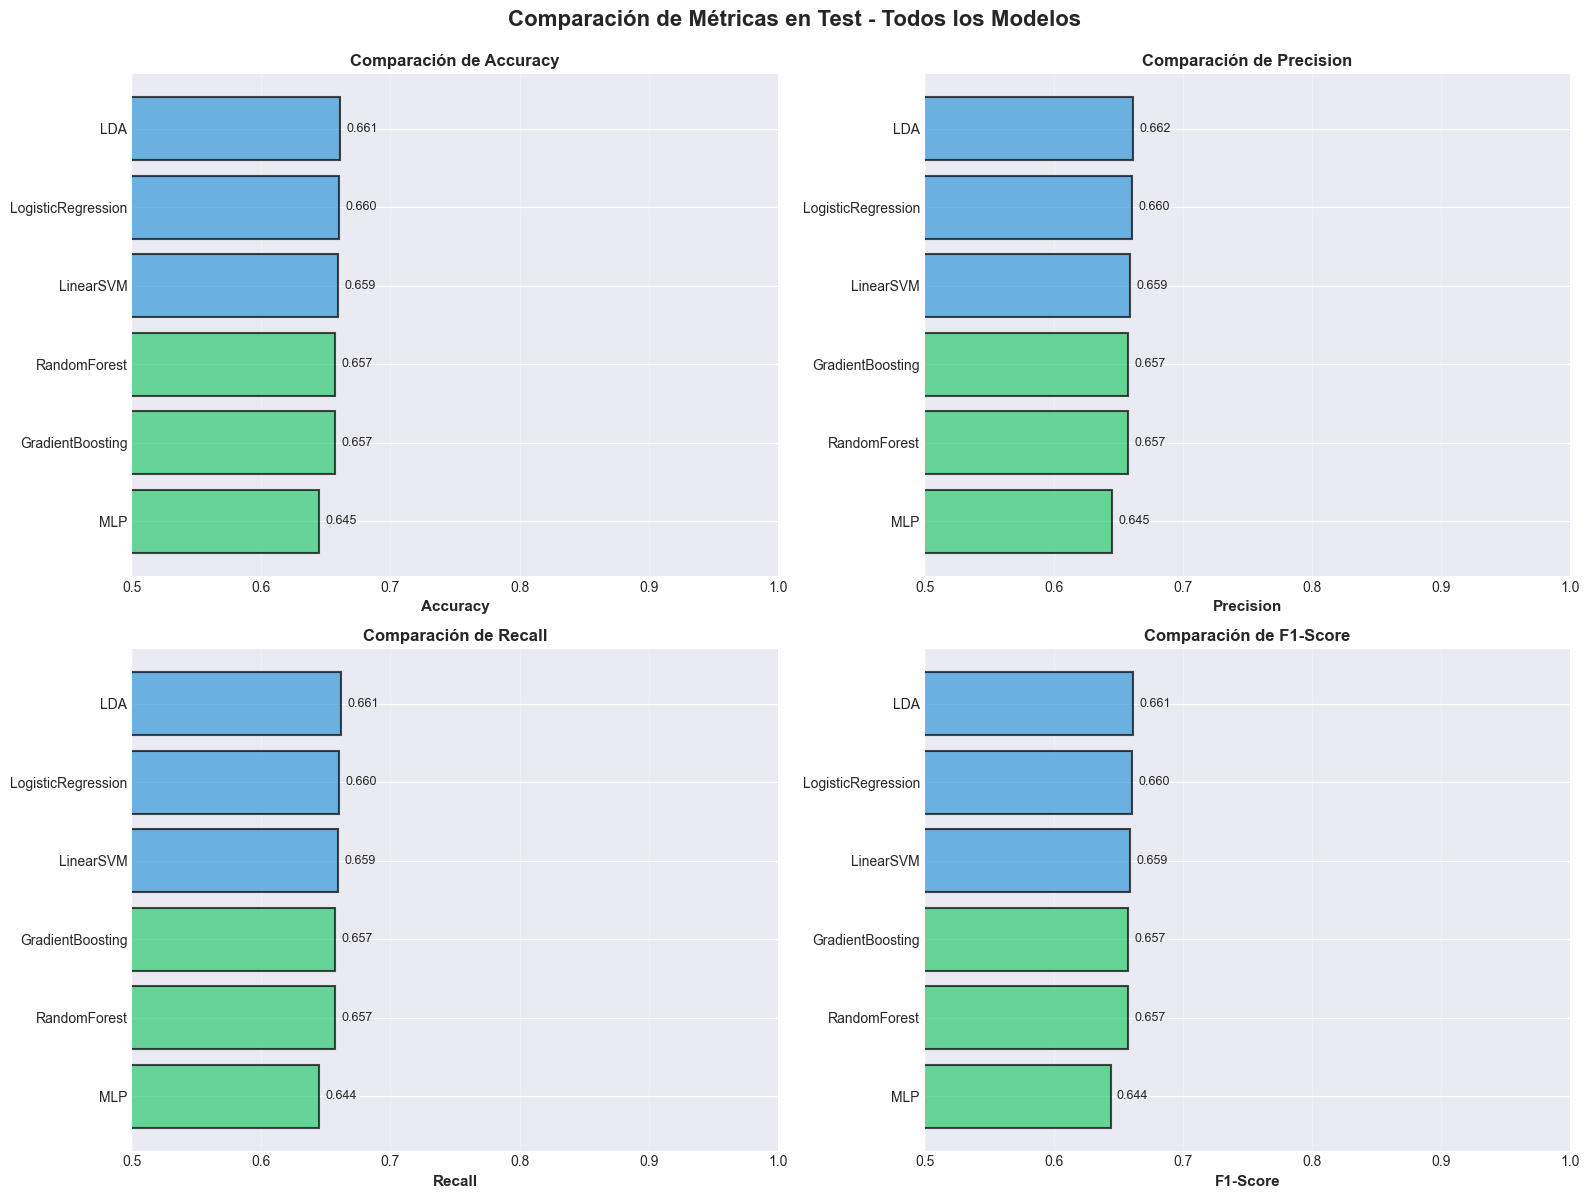

In [31]:
# Tabla resumen de métricas en test
print("TABLA RESUMEN - EVALUACIÓN EN TEST\n")
print(df_resultados_finales.to_string(index=False))

# Visualización comparativa de métricas en test
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Métricas en Test - Todos los Modelos', 
             fontsize=16, fontweight='bold', y=0.995)

lineales = ['LogisticRegression', 'LDA', 'LinearSVM']
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Ordenar por la métrica actual
    df_sorted = df_resultados_finales.sort_values(by=metric, ascending=True)
    colors = ['#3498db' if m in lineales else '#2ecc71' for m in df_sorted['Modelo']]
    
    y_pos = np.arange(len(df_sorted))
    bars = ax.barh(y_pos, df_sorted[metric], color=colors, 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_sorted['Modelo'])
    ax.set_xlabel(metric, fontweight='bold', fontsize=11)
    ax.set_title(f'Comparación de {metric}', fontweight='bold', fontsize=12)
    ax.set_xlim(0.5, 1.0)
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, val in zip(bars, df_sorted[metric]):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 8.4 Detección de Overfitting: Train vs CV vs Test

Análisis de overfitting: Comparación Train vs CV vs Test

Tabla de scores y gaps de generalización:
            Modelo  Train_Acc  CV_Acc  Test_Acc  Gap_Train_Test Nivel_Overfitting
LogisticRegression     0.6705  0.6724    0.6603          0.0102              Bajo
               LDA     0.6703  0.6721    0.6613          0.0090              Bajo
         LinearSVM     0.6700  0.6724    0.6592          0.0108              Bajo
      RandomForest     0.8486  0.6765    0.6573          0.1913              Alto
  GradientBoosting     0.6803  0.6684    0.6573          0.0231              Leve
               MLP     0.6909  0.6670    0.6447          0.0461              Leve


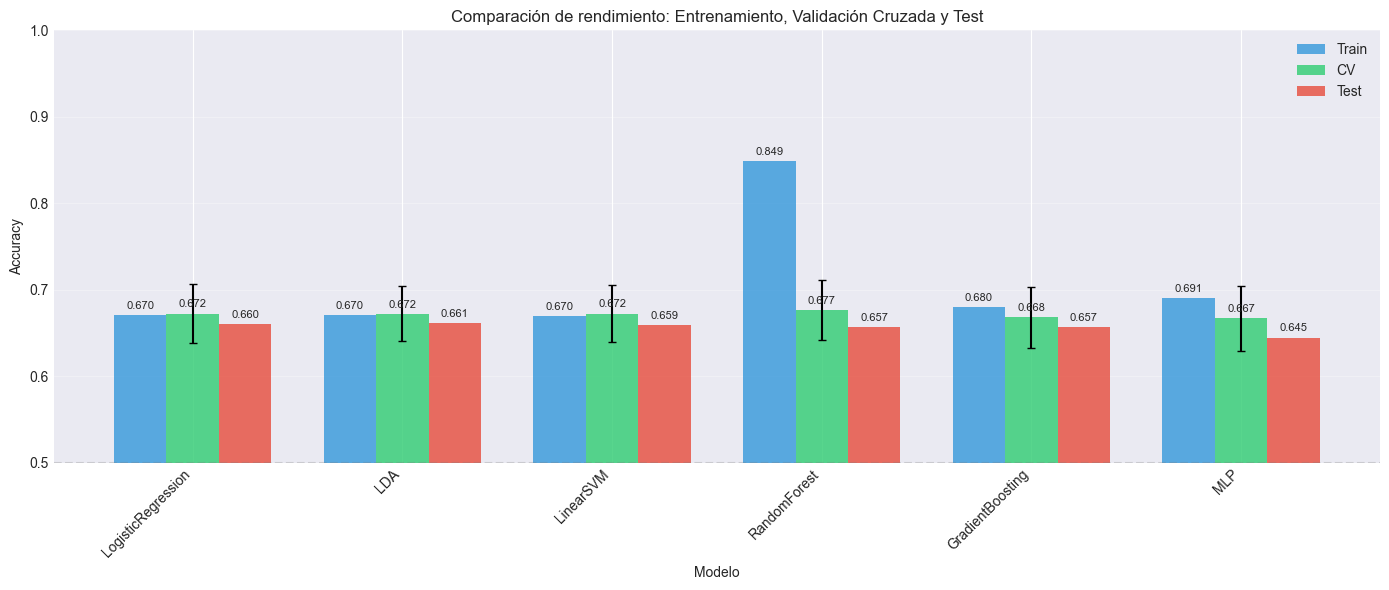

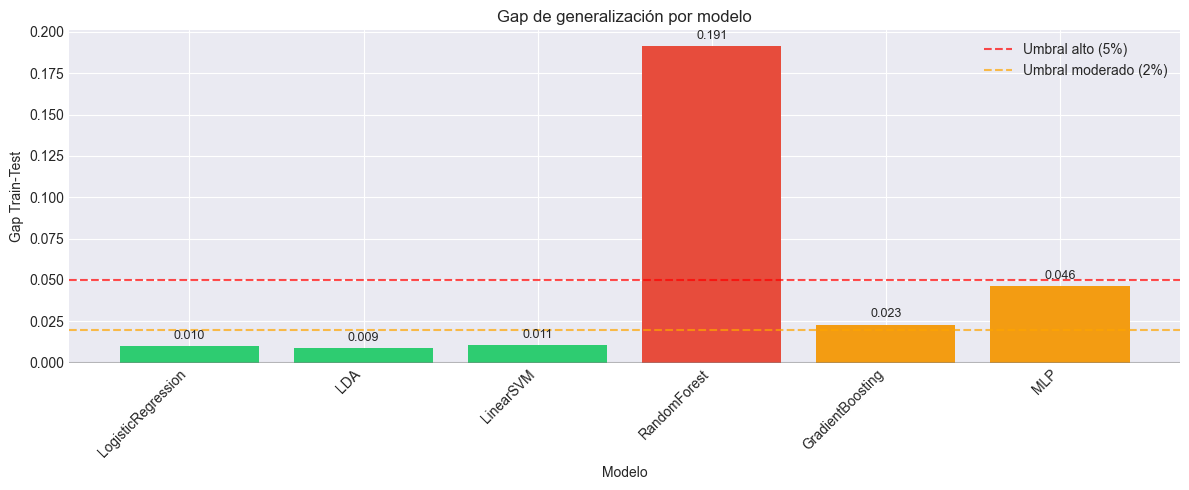


Interpretación de gaps de generalización:

LogisticRegression:
  Train: 0.6705 | CV: 0.6724 ± 0.0343 | Test: 0.6603
  Nivel de overfitting: Bajo

LDA:
  Train: 0.6703 | CV: 0.6721 ± 0.0318 | Test: 0.6613
  Nivel de overfitting: Bajo

LinearSVM:
  Train: 0.6700 | CV: 0.6724 ± 0.0327 | Test: 0.6592
  Nivel de overfitting: Bajo

RandomForest:
  Train: 0.8486 | CV: 0.6765 ± 0.0347 | Test: 0.6573
  Gap Train-CV: 0.172 (el modelo puede estar sobreajustando)
  Nivel de overfitting: Alto

GradientBoosting:
  Train: 0.6803 | CV: 0.6684 ± 0.0353 | Test: 0.6573
  Nivel de overfitting: Leve

MLP:
  Train: 0.6909 | CV: 0.6670 ± 0.0373 | Test: 0.6447
  Nivel de overfitting: Leve


In [32]:
print("Análisis de overfitting: Comparación Train vs CV vs Test")

# Cargar métricas de CV desde el JSON
with open('optimized_params.json', 'r') as f:
    saved_data = json.load(f)

cv_metrics_loaded = saved_data.get('cv_metrics', {})

overfitting_analysis = []

for model_name, model in trained_models.items():
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    if model_name in cv_metrics_loaded:
        cv_acc_list = cv_metrics_loaded[model_name]['accuracy']
        cv_acc_mean = np.mean(cv_acc_list)
        cv_acc_std = np.std(cv_acc_list)
    else:
        from sklearn.model_selection import cross_val_score, StratifiedKFold
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            model, X_train, y_train, cv=cv, scoring='accuracy')
        cv_acc_mean = cv_scores.mean()
        cv_acc_std = cv_scores.std()

    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_cv_gap = train_acc - cv_acc_mean
    cv_test_gap = cv_acc_mean - test_acc
    train_test_gap = train_acc - test_acc

    overfitting_analysis.append({
        'Modelo': model_name,
        'Train_Acc': train_acc,
        'CV_Acc': cv_acc_mean,
        'CV_Std': cv_acc_std,
        'Test_Acc': test_acc,
        'Gap_Train_CV': train_cv_gap,
        'Gap_CV_Test': cv_test_gap,
        'Gap_Train_Test': train_test_gap
    })

df_overfit = pd.DataFrame(overfitting_analysis)

def classify_overfitting(row):
    if row['Gap_Train_Test'] > 0.10:
        return 'Alto'
    elif row['Gap_Train_Test'] > 0.05:
        return 'Moderado'
    elif row['Gap_Train_Test'] > 0.02:
        return 'Leve'
    else:
        return 'Bajo'

df_overfit['Nivel_Overfitting'] = df_overfit.apply(classify_overfitting, axis=1)

print("\nTabla de scores y gaps de generalización:")
print(df_overfit[['Modelo', 'Train_Acc', 'CV_Acc', 'Test_Acc',
      'Gap_Train_Test', 'Nivel_Overfitting']].to_string(index=False))

# Visualización: Barras agrupadas Train vs CV vs Test
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df_overfit))
width = 0.25

bars1 = ax.bar(x - width, df_overfit['Train_Acc'],
               width, label='Train', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, df_overfit['CV_Acc'], width, label='CV', color='#2ecc71', alpha=0.8,
               yerr=df_overfit['CV_Std'], capsize=3)
bars3 = ax.bar(x + width, df_overfit['Test_Acc'],
               width, label='Test', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Modelo')
ax.set_ylabel('Accuracy')
ax.set_title('Comparación de rendimiento: Entrenamiento, Validación Cruzada y Test')
ax.set_xticks(x)
ax.set_xticklabels(df_overfit['Modelo'], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.5, 1.0])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, label='Baseline')
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Gap de generalización por modelo
fig, ax = plt.subplots(figsize=(12, 5))

colors = ['#e74c3c' if g > 0.05 else '#f39c12' if g > 0.02 else '#2ecc71'
          for g in df_overfit['Gap_Train_Test']]

bars = ax.bar(df_overfit['Modelo'], df_overfit['Gap_Train_Test'], color=colors)
ax.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Umbral alto (5%)')
ax.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Umbral moderado (2%)')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

ax.set_xlabel('Modelo')
ax.set_ylabel('Gap Train-Test')
ax.set_title('Gap de generalización por modelo')
ax.legend()
plt.xticks(rotation=45, ha='right')

for bar, val in zip(bars, df_overfit['Gap_Train_Test']):
    ax.annotate(f'{val:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Interpretación de resultados
print("\nInterpretación de gaps de generalización:")

for _, row in df_overfit.iterrows():
    print(f"\n{row['Modelo']}:")
    print(f"  Train: {row['Train_Acc']:.4f} | CV: {row['CV_Acc']:.4f} ± {row['CV_Std']:.4f} | Test: {row['Test_Acc']:.4f}")

    if row['Gap_Train_CV'] > 0.05:
        print(f"  Gap Train-CV: {row['Gap_Train_CV']:.3f} (el modelo puede estar sobreajustando)")

    if row['Gap_CV_Test'] > 0.03:
        print(f"  Gap CV-Test: {row['Gap_CV_Test']:.3f} (validación cruzada optimista)")
    elif row['Gap_CV_Test'] < -0.02:
        print(f"  Gap CV-Test: {row['Gap_CV_Test']:.3f} (buena generalización)")

    print(f"  Nivel de overfitting: {row['Nivel_Overfitting']}")

### 8.5 Análisis Comparativo por Categoría

Analizamos el rendimiento de:
- **Modelos Lineales**: Logistic Regression, LDA (Linear Discriminant Analysis), Linear SVM
- **Modelos No Lineales**: Random Forest, Gradient Boosting, MLP (Multi-Layer Perceptron)

COMPARACIÓN: MODELOS LINEALES vs NO LINEALES

          Accuracy         Precision          Recall         F1-Score        
              mean     std      mean     std    mean     std     mean     std
Tipo                                                                         
Lineal      0.6603  0.0010    0.6604  0.0012  0.6603  0.0011   0.6602  0.0010
No Lineal   0.6531  0.0072    0.6533  0.0068  0.6530  0.0075   0.6528  0.0077


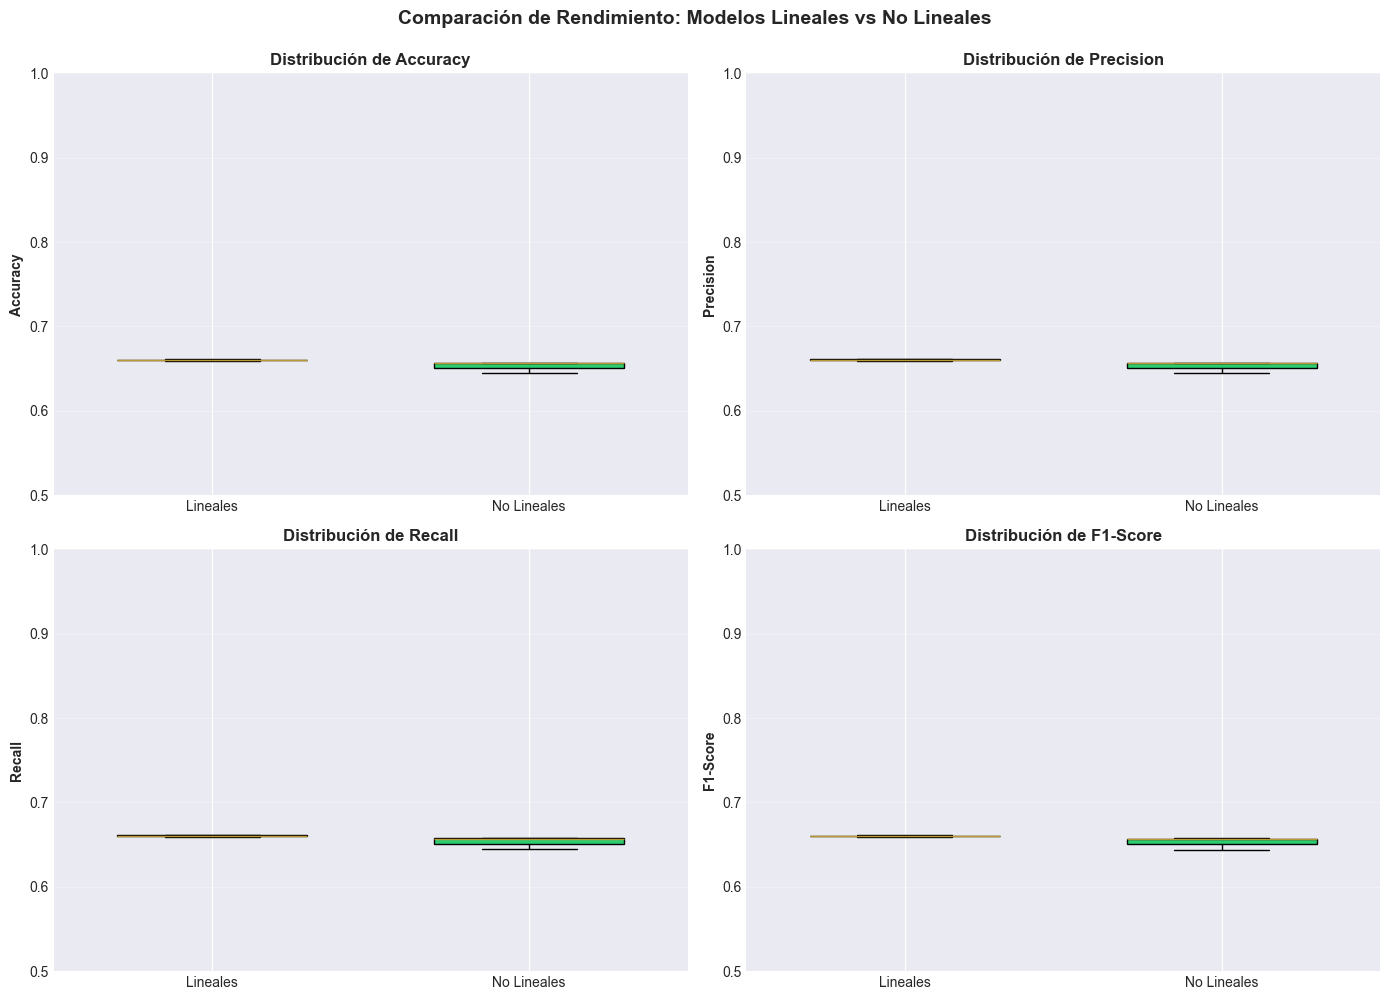

In [33]:
# Análisis comparativo por tipo de modelo (lineal vs no lineal)
lineales = ['LogisticRegression', 'LDA', 'LinearSVM']
no_lineales = ['RandomForest', 'GradientBoosting', 'MLP']

df_resultados_finales['Tipo'] = df_resultados_finales['Modelo'].apply(
    lambda x: 'Lineal' if x in lineales else 'No Lineal'
)

# Estadísticas agregadas por tipo de modelo
grouped = df_resultados_finales.groupby('Tipo')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].agg(['mean', 'std'])

print("COMPARACIÓN: MODELOS LINEALES vs NO LINEALES\n")
print(grouped)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Rendimiento: Modelos Lineales vs No Lineales', 
             fontsize=14, fontweight='bold', y=0.995)

for idx, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
    ax = axes[idx // 2, idx % 2]
    
    # Separar por tipo
    df_lineal = df_resultados_finales[df_resultados_finales['Tipo'] == 'Lineal']
    df_no_lineal = df_resultados_finales[df_resultados_finales['Tipo'] == 'No Lineal']
    
    # Box plot comparativo
    data_to_plot = [df_lineal[metric], df_no_lineal[metric]]
    box = ax.boxplot(data_to_plot, labels=['Lineales', 'No Lineales'], 
                     patch_artist=True, widths=0.6)
    
    # Colores
    box['boxes'][0].set_facecolor('#3498db')
    box['boxes'][1].set_facecolor('#2ecc71')
    
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'Distribución de {metric}', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

### 8.6 Curvas ROC-AUC

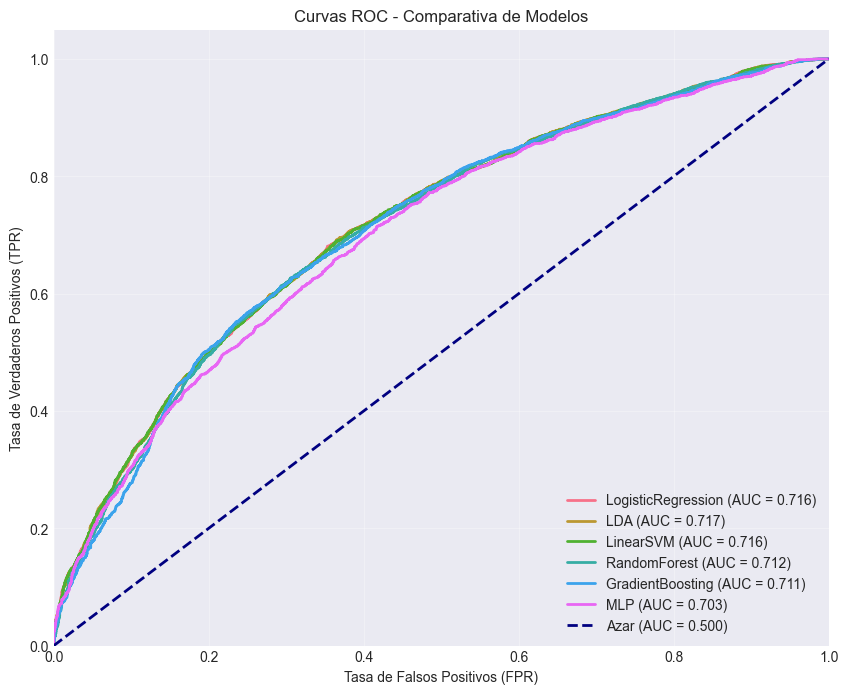

In [34]:
plt.figure(figsize=(10, 8))

# Iteramos sobre todos los modelos entrenados
for name, model in trained_models.items():
    # Solo intentamos graficar si el modelo tiene predict_proba (probabilidad)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Soporte para modelos que usan decision_function (como SVM si no tiene proba activada)
    elif hasattr(model, "decision_function"):
        try:
            y_score = model.decision_function(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
        except:
            pass # Ignoramos si falla

# Línea base (azar)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Comparativa de Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---

## 9. Test Estadístico de Comparación de Modelos

Comparamos estadísticamente los dos mejores modelos usando un test t pareado sobre los scores de validación cruzada.

In [35]:
# Entrenar el mejor modelo según los resultados
best_model_name = df_resultados_finales.iloc[0]['Modelo']
best_params = best_models_params[best_model_name]

print(f"Mejor modelo: {best_model_name}")
print(f"Parámetros: {best_params}")

# Instanciar y entrenar el mejor modelo
if best_model_name == 'LogisticRegression':
    final_model = LogisticRegression(**best_params, solver='lbfgs', max_iter=1000)
elif best_model_name == 'LDA':
    final_model = LinearDiscriminantAnalysis(**best_params)
elif best_model_name == 'LinearSVM':
    final_model = LinearSVC(**best_params, max_iter=2000, dual=True, random_state=42)
elif best_model_name == 'RandomForest':
    final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
elif best_model_name == 'GradientBoosting':
    final_model = GradientBoostingClassifier(**best_params, random_state=42)
elif best_model_name == 'MLP':
    final_model = MLPClassifier(**best_params, max_iter=500, early_stopping=True, random_state=42)

# Entrenar con todo el conjunto de entrenamiento
final_model.fit(X_train, y_train)

print(f"\nModelo final entrenado: {best_model_name}")
print(f"Accuracy en test: {final_model.score(X_test, y_test):.4f}")

# Guardar el mejor modelo
with open('best_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("Mejor modelo guardado en 'best_model.pkl'")

Mejor modelo: LDA
Parámetros: {'solver': 'svd'}

Modelo final entrenado: LDA
Accuracy en test: 0.6613
Mejor modelo guardado en 'best_model.pkl'


In [36]:
# Test t pareado para comparación estadística entre dos modelos
print("\nTEST T PAREADO: COMPARACIÓN ENTRE MEJORES MODELOS\n")

# Selección de los dos mejores modelos por CV accuracy
modelo_A = results_df.index[0]
modelo_B = results_df.index[1]

print(f"Comparando {modelo_A} vs {modelo_B}")
print("=" * 60)

# Comparación en múltiples métricas
for metric_key, metric_label in [('accuracy', 'Accuracy'), ('precision', 'Precision'), 
                                   ('recall', 'Recall'), ('f1', 'F1-Score')]:
    print(f"\nMétrica: {metric_label}")
    
    # Recuperar los scores de CV para esta métrica
    scores_modelo_A = cv_metrics_by_model[modelo_A][metric_key]
    scores_modelo_B = cv_metrics_by_model[modelo_B][metric_key]
    
    print(f"Scores CV {modelo_A}: {scores_modelo_A}")
    print(f"Media: {scores_modelo_A.mean():.4f} ± {scores_modelo_A.std():.4f}")
    print(f"Scores CV {modelo_B}: {scores_modelo_B}")
    print(f"Media: {scores_modelo_B.mean():.4f} ± {scores_modelo_B.std():.4f}")
    
    # Test t pareado: compara si hay diferencia significativa
    stat, p_value = ttest_rel(scores_modelo_A, scores_modelo_B)
    
    print(f"Estadístico t: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpretación del resultado
    if p_value < 0.05:
        print("La diferencia es estadísticamente significativa (p < 0.05)")
        mejor = modelo_A if stat > 0 else modelo_B
        print(f"El modelo con mejor rendimiento en {metric_label} es: {mejor}")
    else:
        print("La diferencia no es estadísticamente significativa (p >= 0.05)")
        print(f"Los modelos tienen un rendimiento comparable en {metric_label}")
    print()


TEST T PAREADO: COMPARACIÓN ENTRE MEJORES MODELOS

Comparando RandomForest vs LogisticRegression

Métrica: Accuracy
Scores CV RandomForest: [0.68816169 0.69562079 0.71775746 0.61573628 0.66530318]
Media: 0.6765 ± 0.0347
Scores CV LogisticRegression: [0.68719923 0.68575553 0.71222329 0.61020212 0.66674687]
Media: 0.6724 ± 0.0343
Estadístico t: 2.0722
P-value: 0.1070
La diferencia no es estadísticamente significativa (p >= 0.05)
Los modelos tienen un rendimiento comparable en Accuracy


Métrica: Precision
Scores CV RandomForest: [0.68572825 0.71282051 0.72878788 0.62629247 0.68415985]
Media: 0.6876 ± 0.0349
Scores CV LogisticRegression: [0.6875     0.70557582 0.7191067  0.62092794 0.68261487]
Media: 0.6831 ± 0.0337
Estadístico t: 2.1641
P-value: 0.0964
La diferencia no es estadísticamente significativa (p >= 0.05)
Los modelos tienen un rendimiento comparable en Precision


Métrica: Recall
Scores CV RandomForest: [0.682393   0.66348449 0.69408369 0.6028436  0.65909091]
Media: 0.6604 ± 0.

### 9.2 Comparación de Predicciones entre Modelos Lineales y No Lineales

Seleccionamos ejemplos relevantes para comparar las predicciones de ambos modelos:
- Predicciones correctas con alta confianza
- Predicciones incorrectas (errores)
- Casos donde los modelos discrepan

In [37]:
# Definir categorías de modelos
LINEAR_MODELS = ['LogisticRegression', 'LDA', 'LinearSVM']
NONLINEAR_MODELS = ['RandomForest', 'GradientBoosting', 'MLP']

# Usar df_overfit que tiene Test_Acc (establecer Modelo como índice)
df_overfit_indexed = df_overfit.set_index('Modelo')

# Obtener resultados para cada tipo de modelo
linear_results = df_overfit_indexed[df_overfit_indexed.index.isin(LINEAR_MODELS)]
nonlinear_results = df_overfit_indexed[df_overfit_indexed.index.isin(NONLINEAR_MODELS)]

# Mejor modelo de cada tipo (basado en Test Accuracy)
best_linear_name = linear_results['Test_Acc'].idxmax()
best_nonlinear_name = nonlinear_results['Test_Acc'].idxmax()

print("MEJORES MODELOS POR TIPO")
print(f"\n Mejor modelo LINEAL: {best_linear_name}")
print(f"   - Test Accuracy: {linear_results.loc[best_linear_name, 'Test_Acc']:.4f}")
print(f"   - CV Accuracy: {linear_results.loc[best_linear_name, 'CV_Acc']:.4f}")

print(f"\n Mejor modelo NO LINEAL: {best_nonlinear_name}")
print(f"   - Test Accuracy: {nonlinear_results.loc[best_nonlinear_name, 'Test_Acc']:.4f}")
print(f"   - CV Accuracy: {nonlinear_results.loc[best_nonlinear_name, 'CV_Acc']:.4f}")

# Obtener los modelos entrenados
best_linear_model = trained_models[best_linear_name]
best_nonlinear_model = trained_models[best_nonlinear_name]

MEJORES MODELOS POR TIPO

 Mejor modelo LINEAL: LDA
   - Test Accuracy: 0.6613
   - CV Accuracy: 0.6721

 Mejor modelo NO LINEAL: RandomForest
   - Test Accuracy: 0.6573
   - CV Accuracy: 0.6765


---

## 10. Interpretabilidad y Análisis del Modelo

### 10.1 Permutation Importance (Análisis Individual)

Calculando Permutation Importance para el mejor modelo: LDA


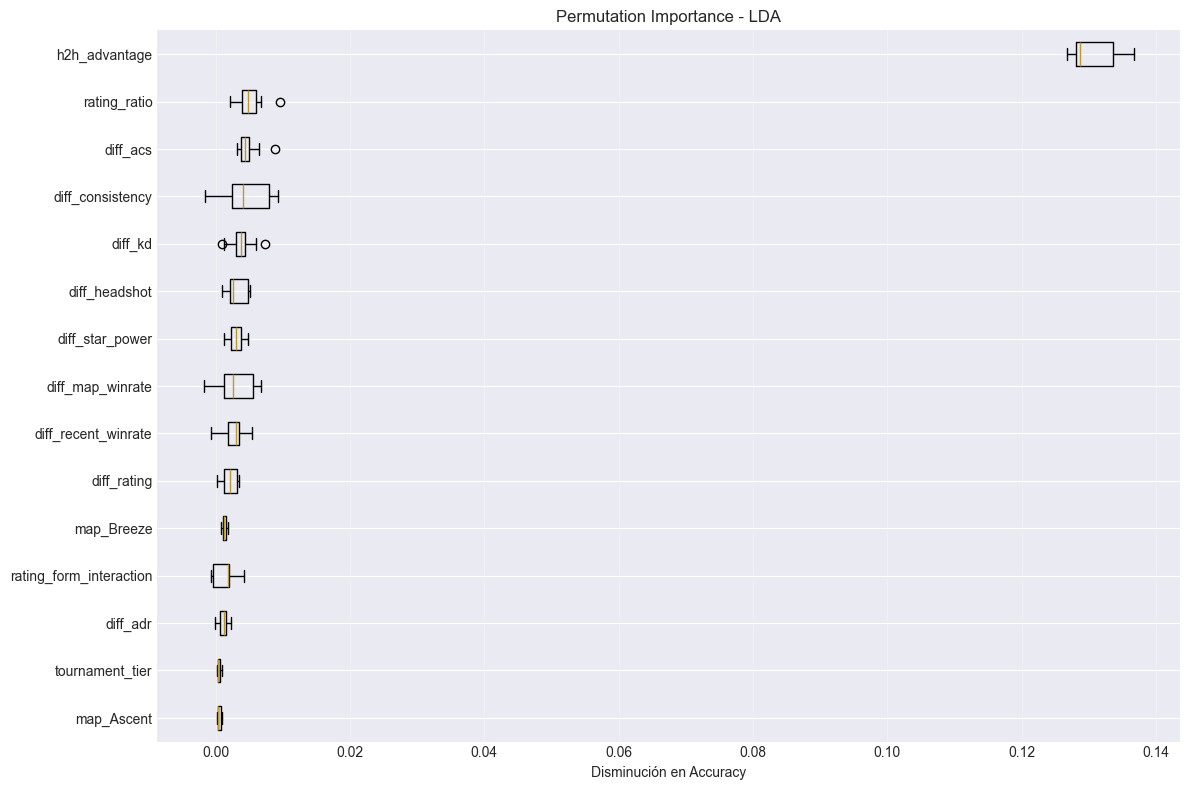

In [38]:
# Permutation Importance del mejor modelo
print(f"Calculando Permutation Importance para el mejor modelo: {best_model_name}")

best_model = trained_models[best_model_name]

# Cálculo de importancia mediante permutación de variables
perm_importance = permutation_importance(
    best_model, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Top 15 variables más importantes
sorted_idx = perm_importance.importances_mean.argsort()[-15:]

# Visualización tipo boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    labels=X_test.columns[sorted_idx]
)
plt.title(f"Permutation Importance - {best_model_name}")
plt.xlabel("Disminución en Accuracy")
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

### 10.2 Comparativa de Permutation Importance entre Modelos

Comparativa de Permutation Importance entre modelos
Calculando para LogisticRegression...
  Top 3: h2h_advantage, rating_ratio, diff_rating
Calculando para LDA...
  Top 3: h2h_advantage, rating_ratio, diff_acs
Calculando para LinearSVM...
  Top 3: h2h_advantage, rating_ratio, diff_rating
Calculando para RandomForest...
  Top 3: h2h_advantage, diff_adr, diff_consistency
Calculando para GradientBoosting...
  Top 3: h2h_advantage, diff_headshot, diff_map_winrate
Calculando para MLP...
  Top 3: h2h_advantage, diff_consistency, rating_ratio


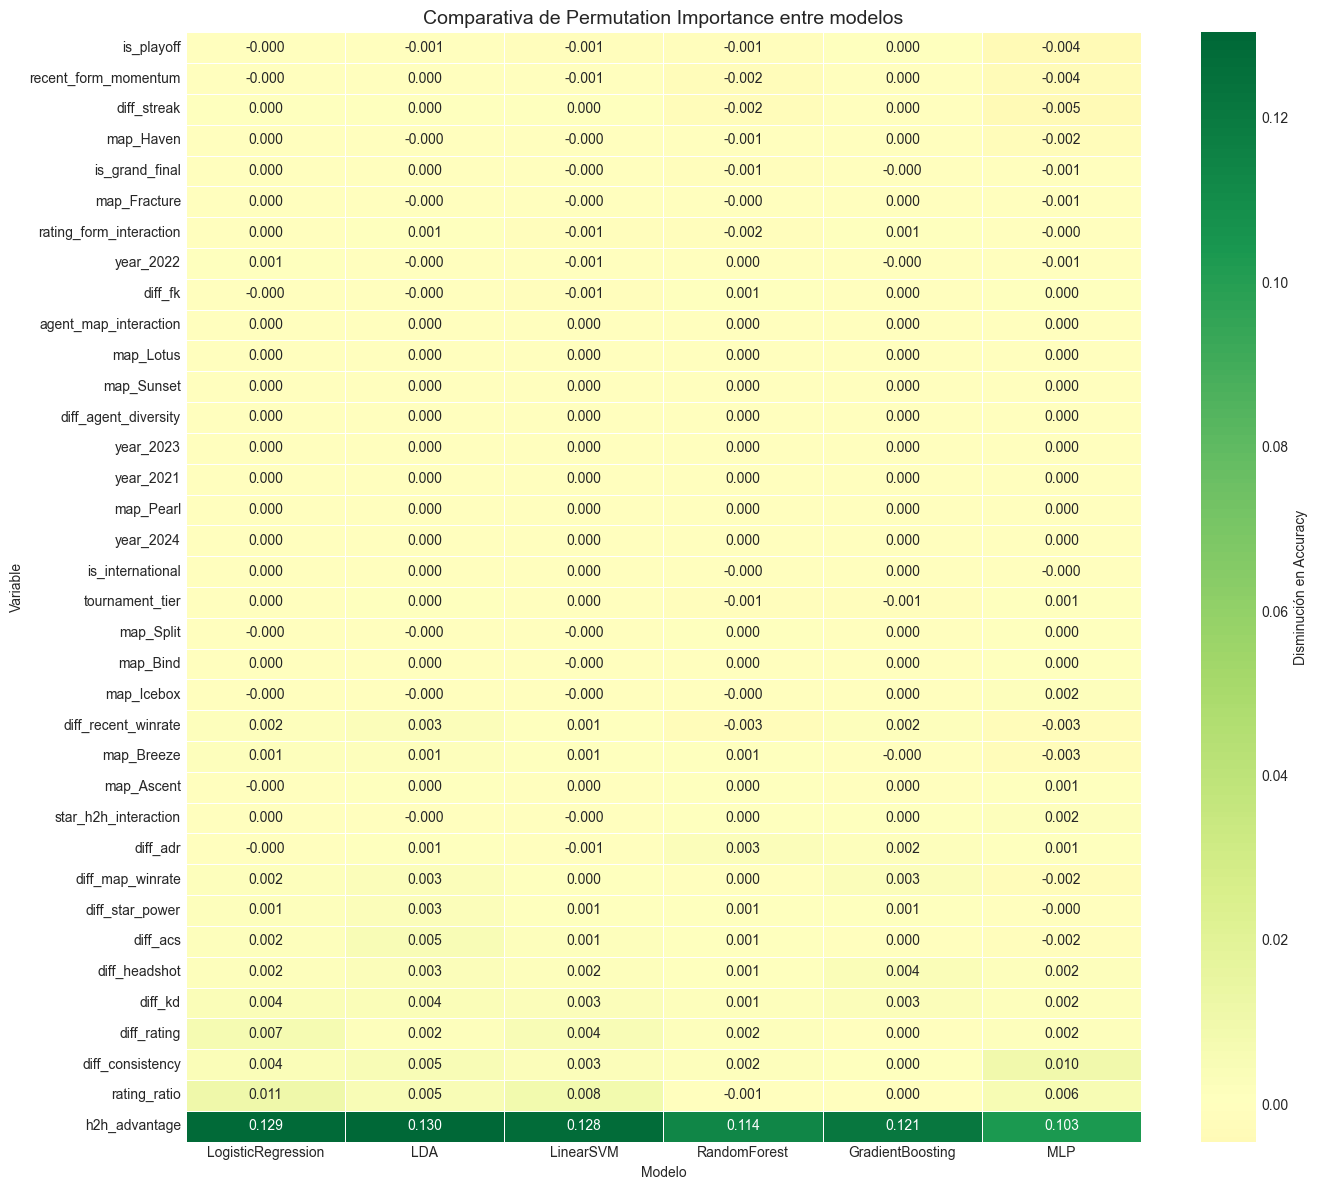

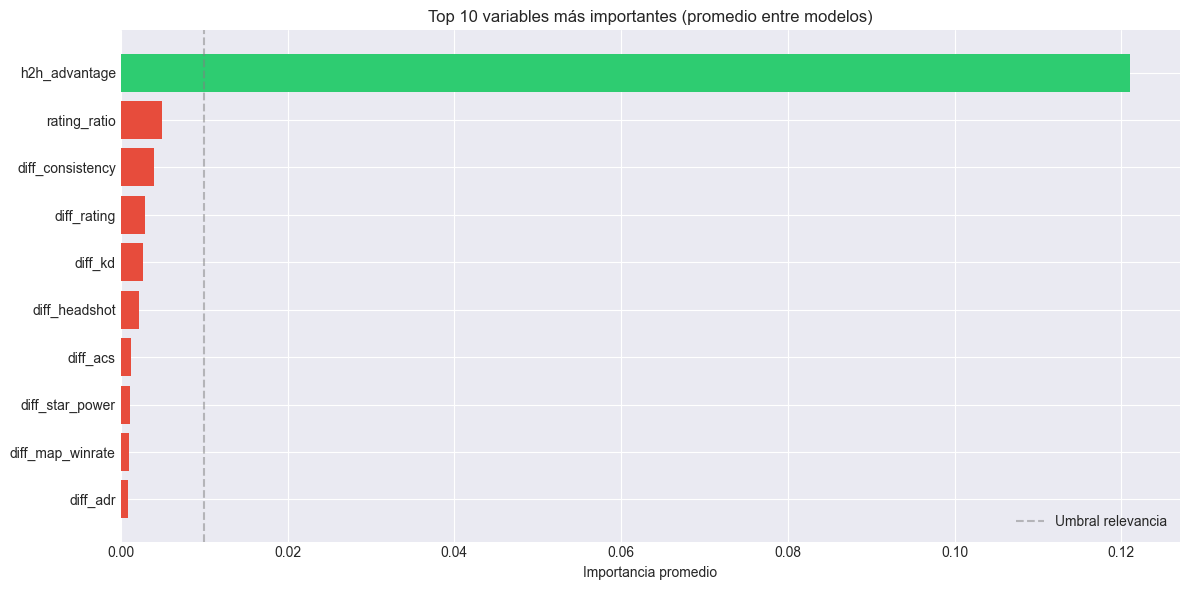

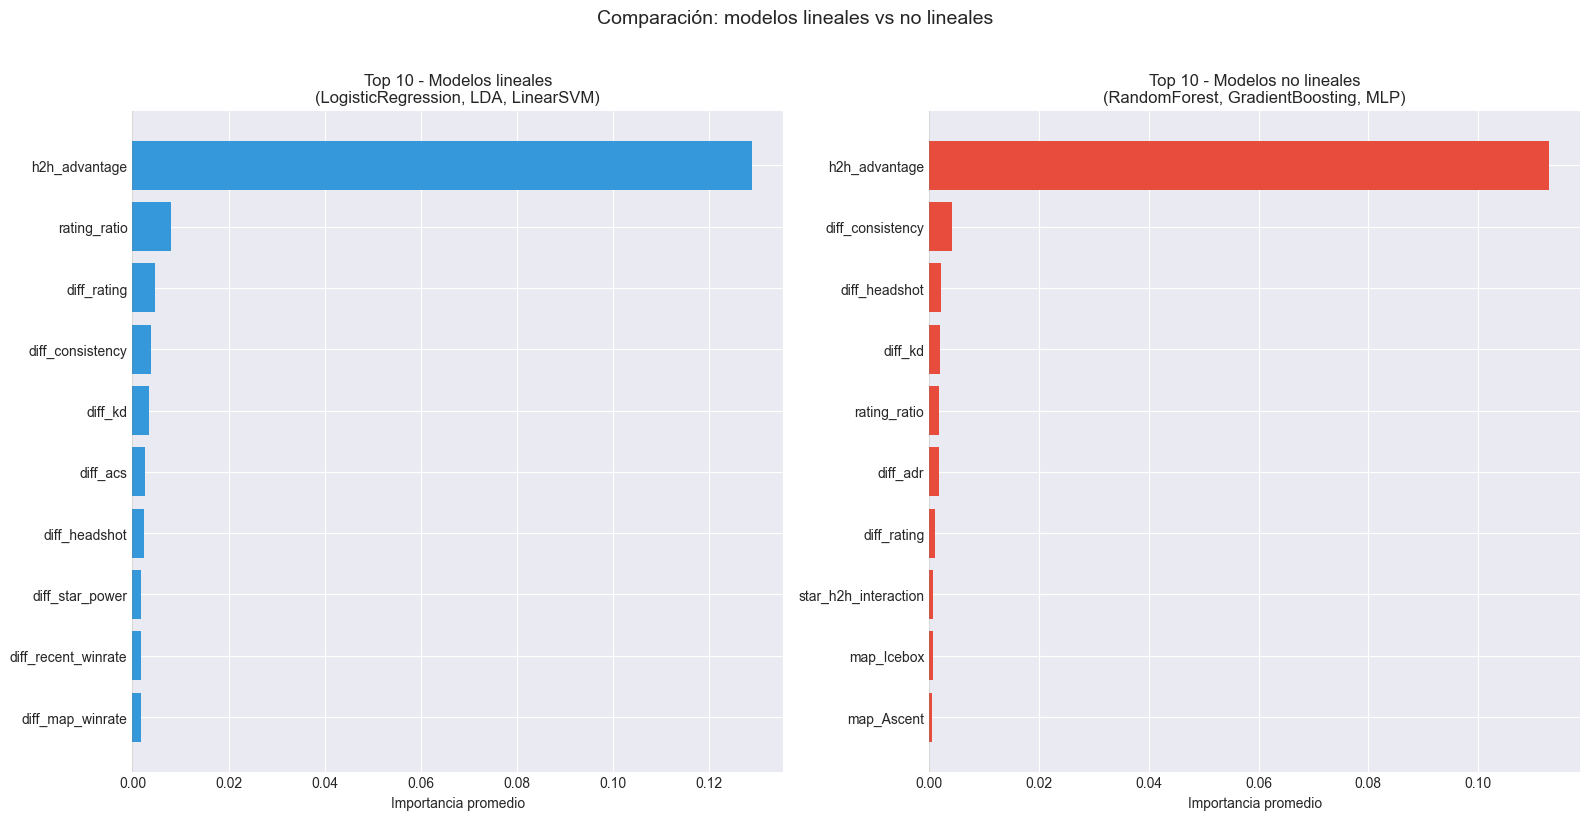


Ranking de top 5 variables por modelo:

LogisticRegression:
  1. h2h_advantage: 0.1286
  2. rating_ratio: 0.0106
  3. diff_rating: 0.0073
  4. diff_consistency: 0.0039
  5. diff_kd: 0.0038

LDA:
  1. h2h_advantage: 0.1304
  2. rating_ratio: 0.0051
  3. diff_acs: 0.0048
  4. diff_consistency: 0.0046
  5. diff_kd: 0.0038

LinearSVM:
  1. h2h_advantage: 0.1281
  2. rating_ratio: 0.0085
  3. diff_rating: 0.0045
  4. diff_consistency: 0.0031
  5. diff_kd: 0.0026

RandomForest:
  1. h2h_advantage: 0.1140
  2. diff_adr: 0.0025
  3. diff_consistency: 0.0020
  4. diff_rating: 0.0016
  5. diff_kd: 0.0014

GradientBoosting:
  1. h2h_advantage: 0.1215
  2. diff_headshot: 0.0037
  3. diff_map_winrate: 0.0030
  4. diff_kd: 0.0027
  5. diff_recent_winrate: 0.0018

MLP:
  1. h2h_advantage: 0.1033
  2. diff_consistency: 0.0101
  3. rating_ratio: 0.0058
  4. map_Icebox: 0.0022
  5. diff_headshot: 0.0020

Análisis de concordancia entre modelos:


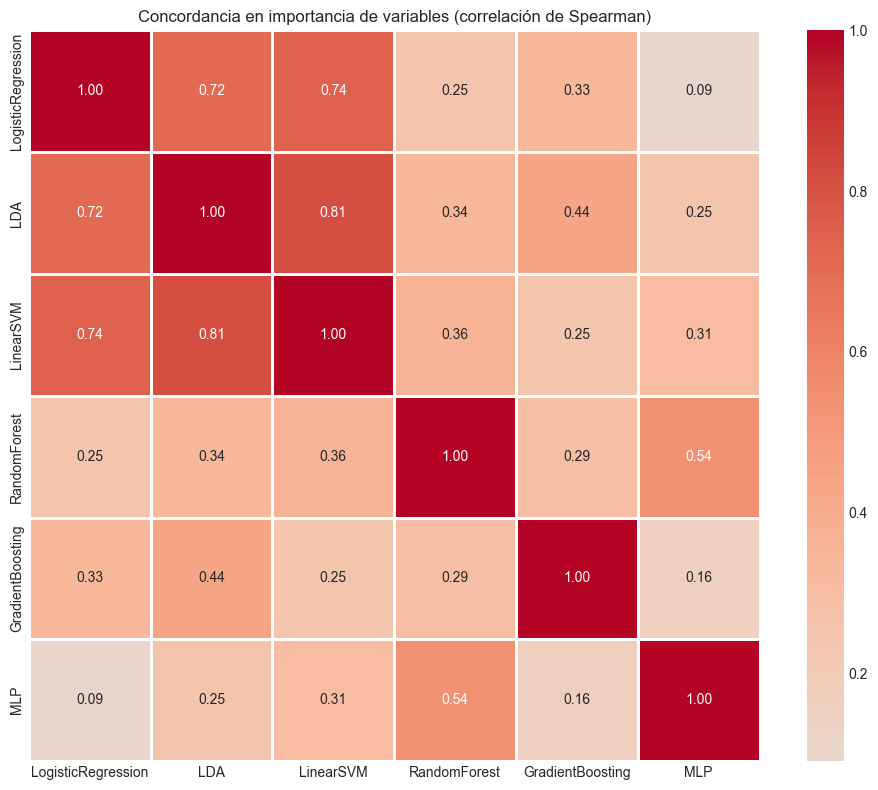


Interpretación de concordancia:
LogisticRegression y LDA: Alta concordancia (0.72)
LogisticRegression y LinearSVM: Alta concordancia (0.74)
LogisticRegression y RandomForest: Baja concordancia (0.25)
LogisticRegression y MLP: Baja concordancia (0.09)
LDA y LinearSVM: Alta concordancia (0.81)
LDA y MLP: Baja concordancia (0.25)
LinearSVM y GradientBoosting: Baja concordancia (0.25)
RandomForest y GradientBoosting: Baja concordancia (0.29)
GradientBoosting y MLP: Baja concordancia (0.16)


In [39]:
# Comparativa de Permutation Importance entre todos los modelos
print("Comparativa de Permutation Importance entre modelos")

perm_importance_results = {}

for model_name, model in trained_models.items():
    print(f"Calculando para {model_name}...")
    
    # Permutación de cada variable y medición del impacto
    perm_imp = permutation_importance(
        model, 
        X_test, 
        y_test, 
        n_repeats=10, 
        random_state=42, 
        n_jobs=-1,
        scoring='accuracy'
    )
    
    perm_importance_results[model_name] = perm_imp.importances_mean
    print(f"  Top 3: {', '.join(X_test.columns[perm_imp.importances_mean.argsort()[-3:][::-1]])}")

# DataFrame con importancias por modelo
df_perm_importance = pd.DataFrame(perm_importance_results, index=X_test.columns)

linear_models = [m for m in ['LogisticRegression', 'LDA', 'LinearSVM'] if m in df_perm_importance.columns]
nonlinear_models = [m for m in ['RandomForest', 'GradientBoosting', 'MLP'] if m in df_perm_importance.columns]

# Heatmap comparativo de todas las variables
plt.figure(figsize=(14, 12))

mean_importance = df_perm_importance.mean(axis=1).sort_values(ascending=True)
df_sorted = df_perm_importance.loc[mean_importance.index]

sns.heatmap(df_sorted, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            linewidths=0.5, cbar_kws={'label': 'Disminución en Accuracy'})
plt.title('Comparativa de Permutation Importance entre modelos', fontsize=14)
plt.xlabel('Modelo')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Top 10 variables más importantes (promedio entre modelos)
plt.figure(figsize=(12, 6))

top_10_features = mean_importance.tail(10)
colors = ['#2ecc71' if v > 0.01 else '#f39c12' if v > 0.005 else '#e74c3c' for v in top_10_features.values]

bars = plt.barh(range(len(top_10_features)), top_10_features.values, color=colors)
plt.yticks(range(len(top_10_features)), top_10_features.index)
plt.xlabel('Importancia promedio')
plt.title('Top 10 variables más importantes (promedio entre modelos)')
plt.axvline(x=0.01, color='gray', linestyle='--', alpha=0.5, label='Umbral relevancia')
plt.legend()
plt.tight_layout()
plt.show()

# Comparación: modelos lineales vs no lineales
if linear_models and nonlinear_models:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top 10 modelos lineales
    linear_mean = df_perm_importance[linear_models].mean(axis=1).sort_values(ascending=True).tail(10)
    axes[0].barh(range(len(linear_mean)), linear_mean.values, color='#3498db')
    axes[0].set_yticks(range(len(linear_mean)))
    axes[0].set_yticklabels(linear_mean.index)
    axes[0].set_xlabel('Importancia promedio')
    axes[0].set_title(f'Top 10 - Modelos lineales\n({", ".join(linear_models)})')
    axes[0].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    # Top 10 modelos no lineales
    nonlinear_mean = df_perm_importance[nonlinear_models].mean(axis=1).sort_values(ascending=True).tail(10)
    axes[1].barh(range(len(nonlinear_mean)), nonlinear_mean.values, color='#e74c3c')
    axes[1].set_yticks(range(len(nonlinear_mean)))
    axes[1].set_yticklabels(nonlinear_mean.index)
    axes[1].set_xlabel('Importancia promedio')
    axes[1].set_title(f'Top 10 - Modelos no lineales\n({", ".join(nonlinear_models)})')
    axes[1].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    plt.suptitle('Comparación: modelos lineales vs no lineales', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Ranking de variables por modelo
print("\nRanking de top 5 variables por modelo:")

for model_name in df_perm_importance.columns:
    top_5 = df_perm_importance[model_name].sort_values(ascending=False).head(5)
    print(f"\n{model_name}:")
    for i, (var, imp) in enumerate(top_5.items(), 1):
        print(f"  {i}. {var}: {imp:.4f}")

# Análisis de concordancia entre modelos (correlación de Spearman)
print("\nAnálisis de concordancia entre modelos:")

correlation_matrix = df_perm_importance.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=1, square=True)
plt.title('Concordancia en importancia de variables (correlación de Spearman)')
plt.tight_layout()
plt.show()

# Interpretación de concordancia
print("\nInterpretación de concordancia:")
for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        corr_val = correlation_matrix.iloc[i, j]
        model_i = correlation_matrix.index[i]
        model_j = correlation_matrix.columns[j]
        
        if corr_val > 0.7:
            print(f"{model_i} y {model_j}: Alta concordancia ({corr_val:.2f})")
        elif corr_val < 0.3:
            print(f"{model_i} y {model_j}: Baja concordancia ({corr_val:.2f})")

### 10.3 Importancia de Variables en Modelo Lineal

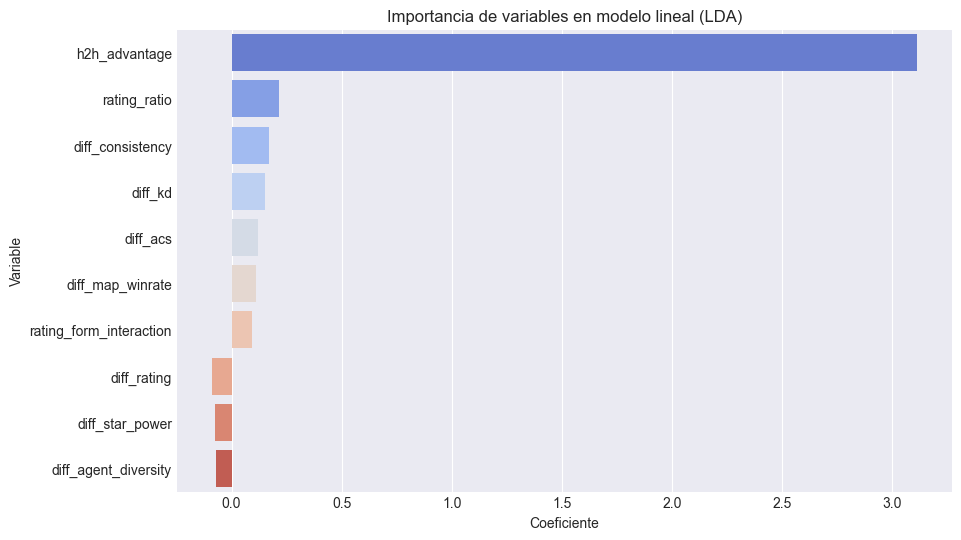

In [40]:
best_linear_params = best_models_params['LDA']
linear_model = LinearDiscriminantAnalysis(**best_linear_params)
linear_model.fit(X_train, y_train)

coefs = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': linear_model.coef_[0],
    'Abs_Coef': np.abs(linear_model.coef_[0])
}).sort_values('Abs_Coef', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=coefs, x='Coeficiente', y='Variable', palette='coolwarm')
plt.title('Importancia de variables en modelo lineal (LDA)')
plt.xlabel('Coeficiente')
plt.show()

### 10.4 Análisis de Predicciones Individuales

In [41]:
# Selección de ejemplos relevantes para análisis
print("SELECCIÓN DE EJEMPLOS RELEVANTES")

# Predicciones de ambos modelos
y_pred_linear = best_linear_model.predict(X_test)
y_pred_nonlinear = best_nonlinear_model.predict(X_test)

# Probabilidades si están disponibles
if hasattr(best_linear_model, 'predict_proba'):
    y_prob_linear = best_linear_model.predict_proba(X_test)[:, 1]
elif hasattr(best_linear_model, 'decision_function'):
    y_prob_linear = best_linear_model.decision_function(X_test)
    y_prob_linear = 1 / (1 + np.exp(-y_prob_linear))  # Sigmoid
else:
    y_prob_linear = y_pred_linear.astype(float)

if hasattr(best_nonlinear_model, 'predict_proba'):
    y_prob_nonlinear = best_nonlinear_model.predict_proba(X_test)[:, 1]
else:
    y_prob_nonlinear = y_pred_nonlinear.astype(float)

# Crear DataFrame de análisis
analysis_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Pred_Linear': y_pred_linear,
    'Pred_NonLinear': y_pred_nonlinear,
    'Prob_Linear': y_prob_linear,
    'Prob_NonLinear': y_prob_nonlinear,
    'Correct_Linear': y_pred_linear == y_test.values,
    'Correct_NonLinear': y_pred_nonlinear == y_test.values,
    'Models_Agree': y_pred_linear == y_pred_nonlinear
}, index=X_test.index)

# Estadísticas generales
print(f"\nTotal de ejemplos en test: {len(analysis_df)}")
print(f"Acuerdo entre modelos: {analysis_df['Models_Agree'].sum()} ({analysis_df['Models_Agree'].mean()*100:.1f}%)")
print(f"Ambos correctos: {((analysis_df['Correct_Linear']) & (analysis_df['Correct_NonLinear'])).sum()}")
print(f"Ambos incorrectos: {((~analysis_df['Correct_Linear']) & (~analysis_df['Correct_NonLinear'])).sum()}")
print(f"Solo {best_linear_name} correcto: {((analysis_df['Correct_Linear']) & (~analysis_df['Correct_NonLinear'])).sum()}")
print(f"Solo {best_nonlinear_name} correcto: {((~analysis_df['Correct_Linear']) & (analysis_df['Correct_NonLinear'])).sum()}")

SELECCIÓN DE EJEMPLOS RELEVANTES

Total de ejemplos en test: 6235
Acuerdo entre modelos: 5714 (91.6%)
Ambos correctos: 3850
Ambos incorrectos: 1864
Solo LDA correcto: 273
Solo RandomForest correcto: 248


In [42]:
# Función para explicar una predicción individual
def explain_prediction(idx, X_test, analysis_df, imp_linear, imp_nonlinear, top_k=8):
    """
    Explica la predicción para un ejemplo específico mostrando
    las características más relevantes y sus valores.
    """
    row = analysis_df.loc[idx]
    features = X_test.loc[idx]
    
    print(f"EJEMPLO: Índice {idx}")
    
    # Información de predicción
    print(f"\n INFORMACIÓN DE PREDICCIÓN:")
    print(f"   • Etiqueta real: {'Victoria' if row['True_Label'] == 1 else 'Derrota'}")
    print(f"   • {best_linear_name}: {'Victoria' if row['Pred_Linear'] == 1 else 'Derrota'} (prob: {row['Prob_Linear']:.3f}) {'✓' if row['Correct_Linear'] else '✗'}")
    print(f"   • {best_nonlinear_name}: {'Victoria' if row['Pred_NonLinear'] == 1 else 'Derrota'} (prob: {row['Prob_NonLinear']:.3f}) {'✓' if row['Correct_NonLinear'] else '✗'}")
    
    # Top características según modelo lineal
    print(f"\n Características más importantes según {best_linear_name}:")
    top_linear_feats = imp_linear.head(top_k)['Feature'].values
    for feat in top_linear_feats:
        val = features[feat]
        print(f"   • {feat}: {val:.4f}")
    
    # Top características según modelo no lineal
    print(f"\n Características más importantes según {best_nonlinear_name}:")
    top_nonlinear_feats = imp_nonlinear.head(top_k)['Feature'].values
    for feat in top_nonlinear_feats:
        val = features[feat]
        print(f"   • {feat}: {val:.4f}")
    
    return row

In [ ]:
# Importancias para modelo lineal
print("Calculando importancias para modelo lineal...")
perm_imp_linear = permutation_importance(
    best_linear_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)
imp_linear = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_imp_linear.importances_mean
}).sort_values('Importance', ascending=False).reset_index(drop=True)

# Importancias para modelo no lineal
print("Calculando importancias para modelo no lineal...")
perm_imp_nonlinear = permutation_importance(
    best_nonlinear_model, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)
imp_nonlinear = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_imp_nonlinear.importances_mean
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print(f"\nTop 5 características - {best_linear_name}:")
print(imp_linear.head())
print(f"\nTop 5 características - {best_nonlinear_name}:")
print(imp_nonlinear.head())

Calculando importancias para modelo lineal...
Calculando importancias para modelo no lineal...

Top 5 características - LDA:
            Feature  Importance
0     h2h_advantage      0.1304
1      rating_ratio      0.0051
2          diff_acs      0.0048
3  diff_consistency      0.0046
4           diff_kd      0.0038

Top 5 características - RandomForest:
            Feature  Importance
0     h2h_advantage      0.1140
1          diff_adr      0.0025
2  diff_consistency      0.0020
3       diff_rating      0.0016
4           diff_kd      0.0014


In [46]:
# Ejemplo 1: Alta confianza, ambos correctos
print("\n" + "─"*70)
print("CASO 1: Predicción correcta con alta confianza (ambos modelos)")
print("─"*70)

high_conf_correct = analysis_df[
    (analysis_df['Correct_Linear']) & 
    (analysis_df['Correct_NonLinear']) &
    (analysis_df['Prob_Linear'] > 0.7) &
    (analysis_df['Prob_NonLinear'] > 0.7)
]

if len(high_conf_correct) > 0:
    # Seleccionar un ejemplo de victoria y uno de derrota si es posible
    victories = high_conf_correct[high_conf_correct['True_Label'] == 1]
    defeats = high_conf_correct[high_conf_correct['True_Label'] == 0]
    
    if len(victories) > 0:
        idx = victories.index[0]
        explain_prediction(idx, X_test, analysis_df, imp_linear, imp_nonlinear)
else:
    print("No se encontraron ejemplos con alta confianza y ambos correctos.")


──────────────────────────────────────────────────────────────────────
CASO 1: Predicción correcta con alta confianza (ambos modelos)
──────────────────────────────────────────────────────────────────────
EJEMPLO: Índice 24951

 INFORMACIÓN DE PREDICCIÓN:
   • Etiqueta real: Victoria
   • LDA: Victoria (prob: 0.819) ✓
   • RandomForest: Victoria (prob: 0.763) ✓

 Características más importantes según LDA:
   • h2h_advantage: 0.3000
   • rating_ratio: 1.0238
   • diff_acs: 1.6988
   • diff_consistency: 0.6502
   • diff_kd: 1.2727
   • diff_headshot: -1.7866
   • diff_star_power: 0.7996
   • diff_map_winrate: 1.3313

 Características más importantes según RandomForest:
   • h2h_advantage: 0.3000
   • diff_adr: 1.4092
   • diff_consistency: 0.6502
   • diff_rating: 1.2153
   • diff_kd: 1.2727
   • diff_star_power: 0.7996
   • diff_fk: 0.5148
   • diff_acs: 1.6988


In [47]:
# Ejemplo 2: Discrepancia entre modelos
print("\n" + "─"*70)
print("CASO 2: Discrepancia entre modelos (predicciones diferentes)")
print("─"*70)

discrepancy = analysis_df[~analysis_df['Models_Agree']]

if len(discrepancy) > 0:
    # Caso donde el lineal acierta y el no lineal falla
    linear_wins = discrepancy[(discrepancy['Correct_Linear']) & (~discrepancy['Correct_NonLinear'])]
    if len(linear_wins) > 0:
        idx = linear_wins.index[0]
        print(f"\n>>> {best_linear_name} acierta, {best_nonlinear_name} falla:")
        explain_prediction(idx, X_test, analysis_df, imp_linear, imp_nonlinear)
    
    # Caso donde el no lineal acierta y el lineal falla
    nonlinear_wins = discrepancy[(~discrepancy['Correct_Linear']) & (discrepancy['Correct_NonLinear'])]
    if len(nonlinear_wins) > 0:
        idx = nonlinear_wins.index[0]
        print(f"\n>>> {best_nonlinear_name} acierta, {best_linear_name} falla:")
        explain_prediction(idx, X_test, analysis_df, imp_linear, imp_nonlinear)
else:
    print("Los modelos coinciden en todas las predicciones.")


──────────────────────────────────────────────────────────────────────
CASO 2: Discrepancia entre modelos (predicciones diferentes)
──────────────────────────────────────────────────────────────────────

>>> LDA acierta, RandomForest falla:
EJEMPLO: Índice 24939

 INFORMACIÓN DE PREDICCIÓN:
   • Etiqueta real: Victoria
   • LDA: Victoria (prob: 0.766) ✓
   • RandomForest: Derrota (prob: 0.410) ✗

 Características más importantes según LDA:
   • h2h_advantage: 0.3000
   • rating_ratio: 0.2504
   • diff_acs: 0.8068
   • diff_consistency: 0.6016
   • diff_kd: -0.1173
   • diff_headshot: -1.3631
   • diff_star_power: 0.0398
   • diff_map_winrate: 1.3313

 Características más importantes según RandomForest:
   • h2h_advantage: 0.3000
   • diff_adr: 0.5469
   • diff_consistency: 0.6016
   • diff_rating: 0.3603
   • diff_kd: -0.1173
   • diff_star_power: 0.0398
   • diff_fk: -0.3956
   • diff_acs: 0.8068

>>> RandomForest acierta, LDA falla:
EJEMPLO: Índice 24974

 INFORMACIÓN DE PREDICCIÓN:

In [48]:
# Ejemplo 3: Error de ambos modelos (caso difícil)
print("\n" + "─"*70)
print("CASO 3: Error de ambos modelos (ejemplo difícil)")
print("─"*70)

both_wrong = analysis_df[
    (~analysis_df['Correct_Linear']) & 
    (~analysis_df['Correct_NonLinear'])
]

if len(both_wrong) > 0:
    # Seleccionar un error con alta confianza (los más interesantes)
    both_wrong_conf = both_wrong[
        (both_wrong['Prob_Linear'] > 0.6) | (both_wrong['Prob_NonLinear'] > 0.6)
    ]
    if len(both_wrong_conf) > 0:
        idx = both_wrong_conf.index[0]
    else:
        idx = both_wrong.index[0]
    
    explain_prediction(idx, X_test, analysis_df, imp_linear, imp_nonlinear)
else:
    print("No hay ejemplos donde ambos modelos fallen.")


──────────────────────────────────────────────────────────────────────
CASO 3: Error de ambos modelos (ejemplo difícil)
──────────────────────────────────────────────────────────────────────
EJEMPLO: Índice 24969

 INFORMACIÓN DE PREDICCIÓN:
   • Etiqueta real: Derrota
   • LDA: Victoria (prob: 0.568) ✗
   • RandomForest: Victoria (prob: 0.697) ✗

 Características más importantes según LDA:
   • h2h_advantage: 0.0000
   • rating_ratio: 0.4811
   • diff_acs: 0.8940
   • diff_consistency: -0.4121
   • diff_kd: 0.6596
   • diff_headshot: 1.0268
   • diff_star_power: 0.3227
   • diff_map_winrate: -0.2918

 Características más importantes según RandomForest:
   • h2h_advantage: 0.0000
   • diff_adr: 0.6543
   • diff_consistency: -0.4121
   • diff_rating: 0.6010
   • diff_kd: 0.6596
   • diff_star_power: 0.3227
   • diff_fk: -0.0268
   • diff_acs: 0.8940


---

## 11. Metricas adicionales

### 11.1 Calibración de Probabilidades

Evaluamos la calidad de las probabilidades predichas por los modelos. Esto es crucial para aplicaciones donde las probabilidades importan (ej: apuestas deportivas, toma de decisiones).

Análisis de calibración de probabilidades
LogisticRegression:
  Brier Score: 0.2165
  Log Loss: 0.6230
LDA:
  Brier Score: 0.2161
  Log Loss: 0.6219
RandomForest:
  Brier Score: 0.2159
  Log Loss: 0.6204
GradientBoosting:
  Brier Score: 0.2166
  Log Loss: 0.6233
MLP:
  Brier Score: 0.2206
  Log Loss: 0.6325

Ranking por Brier Score:
            Modelo  Brier Score  Log Loss
      RandomForest       0.2159    0.6204
               LDA       0.2161    0.6219
LogisticRegression       0.2165    0.6230
  GradientBoosting       0.2166    0.6233
               MLP       0.2206    0.6325


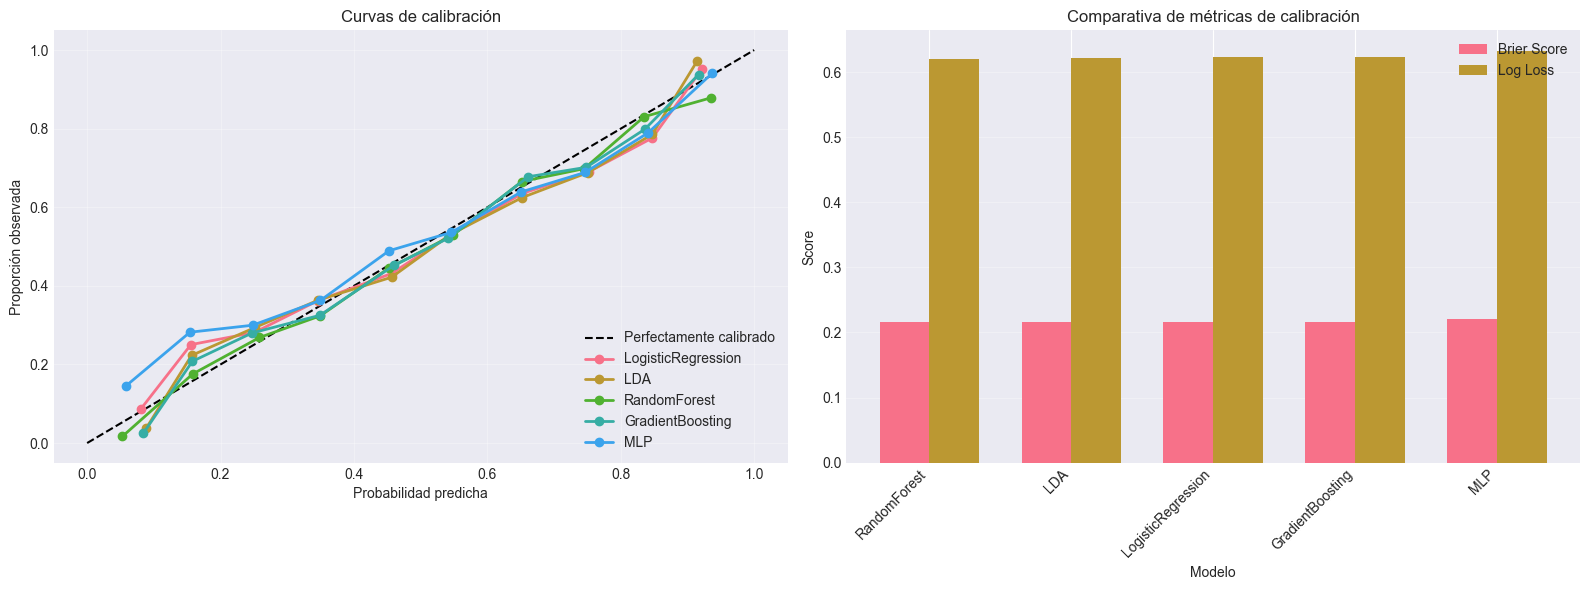

In [49]:
# Análisis de calibración de probabilidades (Brier Score y Log Loss)
print("Análisis de calibración de probabilidades")

calibration_results = []

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Métricas de calibración
        brier = brier_score_loss(y_test, y_prob)
        logloss = log_loss(y_test, y_prob)
        
        calibration_results.append({
            'Modelo': name,
            'Brier Score': brier,
            'Log Loss': logloss
        })
        
        print(f"{name}:")
        print(f"  Brier Score: {brier:.4f}")
        print(f"  Log Loss: {logloss:.4f}")

df_calibration = pd.DataFrame(calibration_results).sort_values('Brier Score')
print("\nRanking por Brier Score:")
print(df_calibration.to_string(index=False))

# Visualización de curvas de calibración
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Curvas de calibración
ax1 = axes[0]
ax1.plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado')

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')
        ax1.plot(prob_pred, prob_true, 'o-', label=name, linewidth=2, markersize=6)

ax1.set_xlabel('Probabilidad predicha')
ax1.set_ylabel('Proporción observada')
ax1.set_title('Curvas de calibración')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Gráfico 2: Comparativa de métricas
ax2 = axes[1]
models_names = df_calibration['Modelo'].tolist()
x_pos = np.arange(len(models_names))

width = 0.35
bars1 = ax2.bar(x_pos - width/2, df_calibration['Brier Score'], width, label='Brier Score')
bars2 = ax2.bar(x_pos + width/2, df_calibration['Log Loss'], width, label='Log Loss')

ax2.set_xlabel('Modelo')
ax2.set_ylabel('Score')
ax2.set_title('Comparativa de métricas de calibración')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 11.2 Curva de validación

Generando curva de validación (max_depth en Random Forest)...


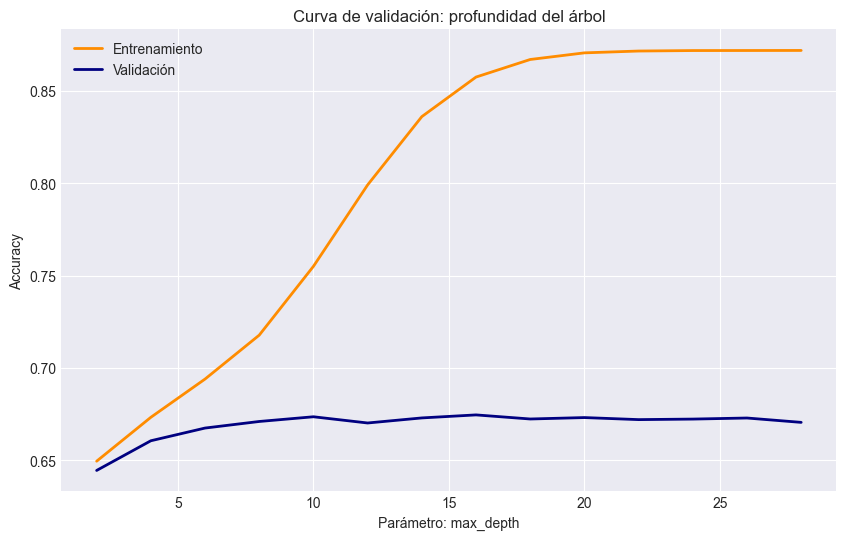

In [50]:
def plot_validation_curve(model, X, y, param_name, param_range, title):
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=TimeSeriesSplit(n_splits=5), scoring="accuracy", n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label="Entrenamiento", color="darkorange", lw=2)
    plt.plot(param_range, test_mean, label="Validación", color="navy", lw=2)
    
    plt.title(title)
    plt.xlabel(f"Parámetro: {param_name}")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

print("Generando curva de validación (max_depth en Random Forest)...")
param_range = np.arange(2, 30, 2)

plot_validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train, 
    "max_depth", 
    param_range, 
    "Curva de validación: profundidad del árbol"
)

### 11.3 Comparación con Baseline (Modelo Dummy)

In [51]:
# Comparación con modelo baseline (DummyClassifier)
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(X_train, y_train)

dummy_pred = dummy_model.predict(X_test)
dummy_acc = accuracy_score(y_test, dummy_pred)

print("Comparación con modelo baseline (DummyClassifier)")
print(f"Accuracy Baseline (predicción mayoritaria): {dummy_acc:.4f}")

# Comparación con todos los modelos
print("\nMejora respecto al baseline:")
for name, acc in df_resultados_finales.set_index('Modelo')['Accuracy'].items():
    mejora = ((acc - dummy_acc) / dummy_acc) * 100
    print(f"{name}: {acc:.4f} (+{mejora:.2f}%)")

Comparación con modelo baseline (DummyClassifier)
Accuracy Baseline (predicción mayoritaria): 0.4949

Mejora respecto al baseline:
LDA: 0.6613 (+33.60%)
LogisticRegression: 0.6603 (+33.41%)
LinearSVM: 0.6592 (+33.18%)
GradientBoosting: 0.6573 (+32.79%)
RandomForest: 0.6573 (+32.79%)
MLP: 0.6447 (+30.27%)


### 11.4 Análisis de Errores de Alta Confianza

In [52]:
# Análisis de errores de alta confianza (predicciones incorrectas con alta probabilidad)
modelo_final = trained_models[best_model_name]
y_probs = modelo_final.predict_proba(X_test)

df_errores = pd.DataFrame({
    'Real': y_test,
    'Predicho': modelo_final.predict(X_test),
    'Probabilidad': y_probs[:, 1],
    'Indice': y_test.index
})

# Detectar errores con alta confianza (probabilidad > 0.75 pero predicción incorrecta)
errores_graves = df_errores[
    (df_errores['Real'] != df_errores['Predicho']) & 
    ((df_errores['Probabilidad'] > 0.75) | (df_errores['Probabilidad'] < 0.25))
]

print(f"Errores de alta confianza detectados: {len(errores_graves)}")

if len(errores_graves) > 0:
    print("\nEjemplo de error con alta confianza:")
    
    idx_error = errores_graves.iloc[0]['Indice']
    info_partida = df.loc[idx_error]
    
    print(f"Partida {idx_error}:")
    print(f"  Predicción: {errores_graves.iloc[0]['Predicho']} (prob: {errores_graves.iloc[0]['Probabilidad']:.2f})")
    print(f"  Real: {errores_graves.iloc[0]['Real']}")
    
    print("\nVariables clave:")
    cols_interes = ['diff_rating', 'diff_acs', 'map_Ascent', 'map_Bind', 'is_grand_final']
    cols_existentes = [c for c in cols_interes if c in df.columns]
    print(info_partida[cols_existentes])

Errores de alta confianza detectados: 515

Ejemplo de error con alta confianza:
Partida 25119.0:
  Predicción: 1.0 (prob: 0.77)
  Real: 0.0

Variables clave:
diff_rating        0.1413
diff_acs          13.9881
map_Ascent         0.0000
map_Bind           0.0000
is_grand_final     0.0000
Name: 25119, dtype: float64


### 11.5 Test de Wilcoxon (Significancia Estadística)

In [53]:
# Test de Wilcoxon para comparación no paramétrica entre dos modelos
model_1_name = results_df.index[0]
model_2_name = results_df.index[1]

print(f"Test de Wilcoxon: {model_1_name} vs {model_2_name}")

# Validación cruzada temporal con 10 folds
cv_time = TimeSeriesSplit(n_splits=10)

scores_1 = cross_val_score(trained_models[model_1_name], X_train, y_train, cv=cv_time, scoring='accuracy')
scores_2 = cross_val_score(trained_models[model_2_name], X_train, y_train, cv=cv_time, scoring='accuracy')

# Test de Wilcoxon (alternativa no paramétrica al test t pareado)
stat, p_value = wilcoxon(scores_1, scores_2)

print(f"\nScores {model_1_name}: {scores_1}")
print(f"Scores {model_2_name}: {scores_2}")
print(f"\nEstadístico de Wilcoxon: {stat}")
print(f"P-valor: {p_value:.5f}")

print("\nInterpretación:")
if p_value < 0.05:
    print(f"Existe diferencia estadísticamente significativa entre {model_1_name} y {model_2_name} (p < 0.05).")
else:
    print(f"No se encuentra diferencia estadísticamente significativa entre los modelos (p >= 0.05).")

Test de Wilcoxon: RandomForest vs LogisticRegression

Scores RandomForest: [0.62284958 0.7375386  0.68548743 0.66034407 0.70489634 0.74194971
 0.66210851 0.58050287 0.6541685  0.67798853]
Scores LogisticRegression: [0.63431848 0.72783414 0.67534186 0.65857962 0.67490075 0.7375386
 0.63917071 0.5893251  0.6576974  0.68019409]

Estadístico de Wilcoxon: 18.0
P-valor: 0.37500

Interpretación:
No se encuentra diferencia estadísticamente significativa entre los modelos (p >= 0.05).


### 11.6 Análisis de Curvas de Aprendizaje (Diagnóstico de Bias/Variance)

Generando curva de aprendizaje para LDA...


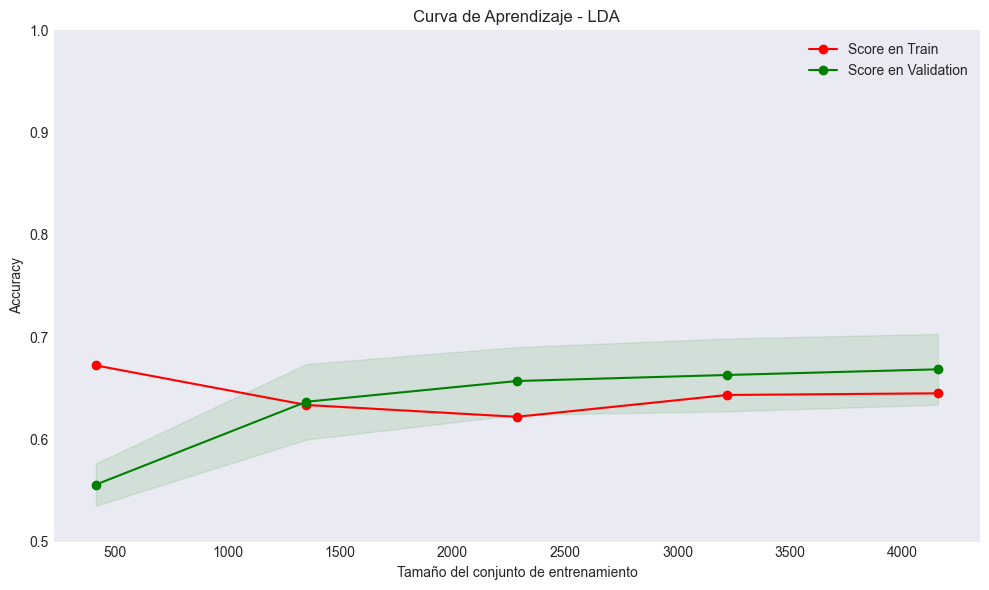

In [54]:
# Análisis de curvas de aprendizaje para diagnóstico de bias-variance
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Genera curvas de aprendizaje para visualizar bias-variance tradeoff.
    - Bias alto: curvas bajas y convergentes
    - Variance alta: gran gap entre train y validation
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Accuracy")

    # Cálculo de learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    
    # Banda de confianza para train
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    # Banda de confianza para validation
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Curvas principales
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score en Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score en Validation")

    plt.legend(loc="best")
    plt.ylim([0.5, 1.0])
    plt.tight_layout()
    return plt

# Generación de curvas de aprendizaje para los mejores modelos
print(f"Generando curva de aprendizaje para {best_model_name}...")

cv_split = TimeSeriesSplit(n_splits=5)
plot_learning_curve(
    trained_models[best_model_name], 
    f"Curva de Aprendizaje - {best_model_name}", 
    X_train, 
    y_train, 
    cv=cv_split, 
    n_jobs=-1
)
plt.show()